# SHAP STATE III feature selection #
## Code to select feature with combination of LightGBM and SHAP ##

## Parameters cell ##

Parameters are overiddent by papermill when run inside DVC stages



In [41]:
n_folds = 5 # this sets global setting of which how many bootstraps to use
n_hold_out = 0
repeats = 10
min_genes = 5
max_genes = 12
importance_type = "split"
stage_num = 3
opt_metrics = "huber"

life_history = ["lifespan", "mass_kg", "mtGC", "metabolic_rate", "temperature", "gestation_days"]
trait = "lifespan"
debug_local = True #to use local version

In [42]:
from pathlib import Path
import sys
import inspect

#lgb_params["importance_type"] = importance_type

local = (Path("..") / "yspecies").resolve()
if debug_local and local.exists():
  sys.path.insert(0, Path("..").as_posix())
  #sys.path.insert(0, local.as_posix())
  print("extending pathes with local yspecies")
  print(sys.path)
  %load_ext autoreload
  %autoreload 2

extending pathes with local yspecies
['..', '..', '/data/sources/yspecies/notebooks', '/data/miniconda3/envs/yspecies/lib/python38.zip', '/data/miniconda3/envs/yspecies/lib/python3.8', '/data/miniconda3/envs/yspecies/lib/python3.8/lib-dynload', '', '/data/miniconda3/envs/yspecies/lib/python3.8/site-packages', '/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/IPython/extensions', '/home/anton/.ipython']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from dataclasses import dataclass, replace
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
from typing import *
from yspecies.dataset import *
from yspecies.utils import *
from yspecies.workflow import TupleWith, Repeat, Collect
from yspecies.config import *
from yspecies.preprocess import FeatureSelection, DataExtractor
from yspecies.partition import DataPartitioner, PartitionParameters
from yspecies.models import Metrics

In [45]:
import optuna
from optuna import Study, Trial
from optuna import multi_objective
from optuna.multi_objective import trial
from optuna.multi_objective.study import MultiObjectiveStudy
from yspecies.tuning import MultiObjectiveResults

In [46]:
#settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import pprint
pp = pprint.PrettyPrinter(indent=4)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)

#charts settings
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib auto
plt.ioff()
set_matplotlib_formats('svg')

Using matplotlib backend: agg


### Loading data ###
Let's load data from species/genes/expressions selected by select_samples.py notebook

In [47]:
from pathlib import Path
locations: Locations = Locations("./") if Path("./data").exists() else Locations("../")
suffix = f"_{stage_num}"
suffix

'_3'

In [48]:
from loguru import logger
logger.add(locations.logs / f"stage{suffix}_shap_selection.log", rotation="12:00")     # New file is created each day at noon

2

In [49]:
stage_folder = locations.interim.dir / f"stage{suffix}" 
stage_folder.mkdir(exist_ok=True)
partitions_folder = stage_folder  / "partitions"
partitions_folder.mkdir(exist_ok=True)

In [50]:
data = ExpressionDataset.from_folder(locations.interim.dir / f"stage_{stage_num-1}" / "input")
data

<table border='2'><caption>input<caption><tr><th>expressions</th><th>genes</th><th>species</th><th>samples</th><th>Genes Metadata</th><th>Species Metadata</th></tr><tr><td>(408, 154)</td><td>(154, 37)</td><td>38</td><td>408</td><td>(154, 2)</td><td>(38, 18)</td></tr></table>

### Loading genes from the ranked selection ###

In [51]:
intersections = locations.output.intersections
ranked = pd.read_csv(intersections / "intersections_ranked.tsv", sep="\t", index_col="reference_gene")
print(ranked.shape)
ranked.head(10)

(152, 23)


symbol   rank  ranks_sum  repeats_rank  shap_rank  \
reference_gene                                                         
ENSG00000188747     NOXA1  1.000     57.000         2.000     12.000   
ENSG00000170835       CEL  2.000     65.000         1.000      7.000   
ENSG00000136436  CALCOCO2  3.000     74.000         7.000     27.000   
ENSG00000198663   C6orf89  4.000     75.000        10.000     35.000   
ENSG00000172531    PPP1CA  5.000     80.000         5.000     42.000   
ENSG00000006282   SPATA20  6.000     86.000         8.000     25.000   
ENSG00000142002      DPP9  7.000     87.000         4.000     26.000   
ENSG00000129187      DCTD  8.000     89.000         8.000     32.000   
ENSG00000165501      LRR1  9.000     93.000         2.000     19.000   
ENSG00000120675   DNAJC15 10.000     94.000         8.000     52.000   

                 kendall_tau_rank  frequency_rank  tissue_linear_rank  \
reference_gene                                                          
ENSG00000188747            16.000           1.000              10.000   
ENSG00000170835             7.000           6.000              33.000   
ENSG00000136436             5.000           7.000              18.000   
ENSG00000198663             1.000           2.000              12.000   
ENSG00000172531             3.000          20.000              13.000   
ENSG00000006282            31.000          16.000               5.000   
ENSG00000142002            11.000          11.000              29.000   
ENSG00000129187            26.000           8.000               6.000   
ENSG00000165501            14.000           9.000              41.000   
ENSG00000120675             9.000          20.000               8.000   

                 genage_rank  repeats_all  repeats  mean_abs_shap  \
reference_gene                                                      
ENSG00000188747           17       19.000   10.000          0.507   
ENSG00000170835           17       20.000   10.000          0.849   
ENSG00000136436           17       14.000   10.000          0.307   
ENSG00000198663           17       10.000   10.000          0.226   
ENSG00000172531           17       16.000   10.000          0.165   
ENSG00000006282           17       13.000   10.000          0.311   
ENSG00000142002           17       17.000   10.000          0.309   
ENSG00000129187           17       13.000   10.000          0.253   
ENSG00000165501           17       19.000   10.000          0.366   
ENSG00000120675           17       13.000   10.000          0.128   

                 mean_kendall_tau  frequency  max_linear_r2  genage_count  \
reference_gene                                                              
ENSG00000188747             0.697      1.000          0.627         0.000   
ENSG00000170835             0.746      0.600          0.481         0.000   
ENSG00000136436             0.763      0.420          0.559         0.000   
ENSG00000198663            -0.788      0.940          0.616         0.000   
ENSG00000172531            -0.782      0.000          0.610         0.000   
ENSG00000006282             0.649      0.080          0.675         0.000   
ENSG00000142002            -0.717      0.300          0.507         0.000   
ENSG00000129187             0.674      0.400          0.666         0.000   
ENSG00000165501             0.715      0.340          0.459         0.000   
ENSG00000120675            -0.735      0.000          0.646         0.000   

                   direction  repeats_lifespan_stage_1  \
reference_gene                                           
ENSG00000188747   strong pro                     9.000   
ENSG00000170835   strong pro                    10.000   
ENSG00000136436   strong pro                     4.000   
ENSG00000198663  strong anti                     0.000   
ENSG00000172531  strong anti                     6.000   
ENSG00000006282   strong pro                     3.000   
ENSG00000142002  strong anti                     7.000   
E

In [52]:
def data_genes(genes: List[str]):
    return data.by_genes.collect(lambda gs: gs.loc[genes])

def data_head(num: int):
    return data_genes(ranked.head(num).index.to_list())

## Setting up features to select ##

In [53]:
default_selection = FeatureSelection(
    samples = ["tissue","species"], #samples metadata to include
    species =  [], #species metadata other then Y label to include
    exclude_from_training = ["species"],  #exclude some fields from LightGBM training
    to_predict = "lifespan", #column to predict
    categorical = ["tissue"],
    select_by = "shap",
    importance_type =  importance_type,
    feature_perturbation = "tree_path_dependent"
)
default_selection

FeatureSelection(samples=['tissue', 'species'], species=[], genes=None, to_predict='lifespan', categorical=['tissue'], exclude_from_training=['species'], genes_meta=None, select_by='shap', importance_type='split', feature_perturbation='tree_path_dependent', not_validated_species=[])

In [54]:
def selection(num: int, trait: str = "lifespan", criteria = default_selection):
    d = data_head(num)
    return (d,  replace(criteria, to_predict = trait, not_validated_species = d.min_max_trait(trait) ))
selection(10)[1]

FeatureSelection(samples=['tissue', 'species'], species=[], genes=None, to_predict='lifespan', categorical=['tissue'], exclude_from_training=['species'], genes_meta=None, select_by='shap', importance_type='split', feature_perturbation='tree_path_dependent', not_validated_species=['Mus_caroli', 'Homo_sapiens'])

### Setting up pipelines ###

In [55]:
from yspecies.helpers import PipelineFactory
factory = PipelineFactory(locations, repeats, n_folds, n_hold_out)

In [56]:
def opt_by_trait(trait: str, sufix: str = ""):
    return locations.interim.optimization / f"{trait}{sufix}.sqlite"

In [57]:
lifespan_pipeline = factory.make_repeated_shap_pipeline(study_path = opt_by_trait(trait, f"_{stage_num}"), study_name=f"{trait}_r2_huber_kendall", opt_metrics = opt_metrics)
#pipelines = {trait:factory.make_shap_pipeline(trait) for trait in life_history}
lifespan_pipeline

create_study is experimental (supported from v1.4.0). The interface can change in the future.
NSGAIIMultiObjectiveSampler is experimental (supported from v1.5.0). The interface can change in the future.
RandomMultiObjectiveSampler is experimental (supported from v1.4.0). The interface can change in the future.
[I 2020-11-15 05:21:02,920] Using an existing study with name 'lifespan_r2_huber_kendall' instead of creating a new one.


loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/lifespan_3.sqlite


MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.


Pipeline(steps=[('extractor', DataExtractor()),
                ('prepare_for_partitioning',
                 TupleWith(parameters=PartitionParameters(n_folds=5, n_hold_out=0, species_in_validation=2, seed=42), map_left=<function TupleWith.<lambda>.<locals>.<lambda> at 0x7f1b89cfa820>, map_right=<function TupleWith.<lambda>.<locals>.<lambda> at 0x7f1b89cfa790>)),
                ('repeated_partition_shap',
                 Repea...
                 CrossValidator(early_stopping_rounds=10, models=[], evals=[])),
                ('shap_computation', ShapSelector())]), repeats=10, map=<function PipelineFactory.make_repeated_shap_pipeline.<locals>.<lambda> at 0x7f1b89cfa280>)),
                ('summarize',
                 Collect(fold=<function PipelineFactory.make_repeated_shap_pipeline.<locals>.<lambda> at 0x7f1b89cfa5e0>, filter=<function Collect.<lambda>.<locals>.<lambda> at 0x7f1b89cfa1f0>))])

# Run third stage #

In [58]:
lifespan_results = [lifespan_pipeline.fit_transform(selection(i,"lifespan", default_selection)) for i in range(min_genes, max_genes)] #all genes
len(lifespan_results)

2020-11-15 05:21:05.918 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 0 =====
2020-11-15 05:21:05.920 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}
2020-11-15 05:21:05.925 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument
Early stopping is not available in dart mode
2020-11-15 05:21:06.478 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Capra_hircus']


[250]	valid_0's l1: 8.12107	valid_0's l2: 242.552	valid_0's huber: 6.97419


2020-11-15 05:21:06.996 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


[250]	valid_0's l1: 9.00792	valid_0's l2: 414.4	valid_0's huber: 7.78848


2020-11-15 05:21:07.525 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


[250]	valid_0's l1: 8.49143	valid_0's l2: 386.27	valid_0's huber: 7.33053


2020-11-15 05:21:08.276 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Pan_troglodytes']


[250]	valid_0's l1: 6.69592	valid_0's l2: 175.481	valid_0's huber: 5.69147
[250]	valid_0's l1: 9.34009	valid_0's l2: 321.594	valid_0's huber: 8.08152


2020-11-15 05:21:10.185 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.5536902385170748, MAE=8.331285033063143, MSE=308.0594586516753, huber=7.173235897090071)
2020-11-15 05:21:10.190 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 1 =====
2020-11-15 05:21:10.190 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-11-15 05:21:10.194 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of argument
Ea

[250]	valid_0's l1: 8.78448	valid_0's l2: 235.096	valid_0's huber: 7.57221


2020-11-15 05:21:11.297 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 9.5929	valid_0's l2: 422.227	valid_0's huber: 8.30158


2020-11-15 05:21:11.865 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


[250]	valid_0's l1: 8.49087	valid_0's l2: 357.226	valid_0's huber: 7.32422


2020-11-15 05:21:12.377 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 9.73708	valid_0's l2: 277.701	valid_0's huber: 8.42847
[250]	valid_0's l1: 7.72284	valid_0's l2: 253.047	valid_0's huber: 6.64631


2020-11-15 05:21:14.250 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.5687166435337708, MAE=8.865633752085888, MSE=309.05926301073856, huber=7.65455575824452)
2020-11-15 05:21:14.255 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 2 =====
2020-11-15 05:21:14.256 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-11-15 05:21:14.259 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of arg

[250]	valid_0's l1: 10.295	valid_0's l2: 371.065	valid_0's huber: 8.9284


2020-11-15 05:21:15.541 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 10.7899	valid_0's l2: 530.376	valid_0's huber: 9.35416


2020-11-15 05:21:16.120 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


[250]	valid_0's l1: 10.1357	valid_0's l2: 503.771	valid_0's huber: 8.79054


2020-11-15 05:21:16.686 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Tupaia_belangeri']


[250]	valid_0's l1: 7.97584	valid_0's l2: 163.226	valid_0's huber: 6.83152
[250]	valid_0's l1: 10.2347	valid_0's l2: 336.018	valid_0's huber: 8.86381


2020-11-15 05:21:18.675 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.4894383831690531, MAE=9.886234097397702, MSE=380.8912781605767, huber=8.553685306092635)
2020-11-15 05:21:18.680 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 3 =====
2020-11-15 05:21:18.681 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-11-15 05:21:18.685 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument

[250]	valid_0's l1: 8.79918	valid_0's l2: 272.251	valid_0's huber: 7.57345


2020-11-15 05:21:19.768 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


[250]	valid_0's l1: 10.0991	valid_0's l2: 426.557	valid_0's huber: 8.74541


2020-11-15 05:21:20.463 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


[250]	valid_0's l1: 9.81302	valid_0's l2: 447.616	valid_0's huber: 8.50562


2020-11-15 05:21:21.030 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


[250]	valid_0's l1: 4.02913	valid_0's l2: 110.35	valid_0's huber: 3.33512
[250]	valid_0's l1: 6.54804	valid_0's l2: 202.907	valid_0's huber: 5.57516


2020-11-15 05:21:22.905 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.5988692674442515, MAE=7.857694079556848, MSE=291.9361456215943, huber=6.746953590812987)
2020-11-15 05:21:22.910 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 4 =====
2020-11-15 05:21:22.911 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-11-15 05:21:22.914 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
Found `early_stopping_round` in params. Will use it instead of argu

[250]	valid_0's l1: 8.57067	valid_0's l2: 266.693	valid_0's huber: 7.39261


2020-11-15 05:21:24.107 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


[250]	valid_0's l1: 9.36037	valid_0's l2: 433.439	valid_0's huber: 8.09504


2020-11-15 05:21:24.624 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


[250]	valid_0's l1: 8.20567	valid_0's l2: 354.905	valid_0's huber: 7.06377


2020-11-15 05:21:25.165 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Equus_caballus']


[250]	valid_0's l1: 8.38874	valid_0's l2: 229.956	valid_0's huber: 7.21092
[250]	valid_0's l1: 8.27178	valid_0's l2: 310.564	valid_0's huber: 7.15558


2020-11-15 05:21:27.160 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.5338934555193353, MAE=8.559444242667134, MSE=319.1113828879364, huber=7.383583181420559)
2020-11-15 05:21:27.165 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 5 =====
2020-11-15 05:21:27.165 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-11-15 05:21:27.169 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
Found `early_stopping_round` in params. Will use it instead of ar

[250]	valid_0's l1: 9.73808	valid_0's l2: 386.826	valid_0's huber: 8.45155


2020-11-15 05:21:28.222 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 7.95234	valid_0's l2: 350.773	valid_0's huber: 6.81542


2020-11-15 05:21:29.010 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 8.62416	valid_0's l2: 375.262	valid_0's huber: 7.43738


2020-11-15 05:21:29.741 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 5.50396	valid_0's l2: 132.36	valid_0's huber: 4.63493
[250]	valid_0's l1: 9.32164	valid_0's l2: 275.978	valid_0's huber: 8.07102


2020-11-15 05:21:32.173 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.5785526560893339, MAE=8.22803433692198, MSE=304.2396430875586, huber=7.082060252205558)
2020-11-15 05:21:32.178 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 6 =====
2020-11-15 05:21:32.179 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-11-15 05:21:32.182 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
Found `early_stopping_round` in params. Will use it inst

[250]	valid_0's l1: 8.184	valid_0's l2: 284.397	valid_0's huber: 7.03493


2020-11-15 05:21:33.288 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


[250]	valid_0's l1: 8.89487	valid_0's l2: 410.866	valid_0's huber: 7.68861


2020-11-15 05:21:33.901 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


[250]	valid_0's l1: 8.15349	valid_0's l2: 373.764	valid_0's huber: 7.00902


2020-11-15 05:21:34.415 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Sus_scrofa']


[250]	valid_0's l1: 7.36755	valid_0's l2: 171.444	valid_0's huber: 6.28368
[250]	valid_0's l1: 8.13722	valid_0's l2: 242.93	valid_0's huber: 7.01136


2020-11-15 05:21:36.312 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.5936830559830094, MAE=8.14742635855242, MSE=296.68009266204143, huber=7.005517448321065)
2020-11-15 05:21:36.317 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 7 =====
2020-11-15 05:21:36.317 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-11-15 05:21:36.320 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
Found `early_stopping_round` in params. Will use it instead of argument


[250]	valid_0's l1: 8.23228	valid_0's l2: 249.202	valid_0's huber: 7.06177


2020-11-15 05:21:37.360 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 8.74348	valid_0's l2: 393.937	valid_0's huber: 7.52673


2020-11-15 05:21:37.887 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


[250]	valid_0's l1: 8.24082	valid_0's l2: 364.239	valid_0's huber: 7.1053


2020-11-15 05:21:38.424 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 6.5443	valid_0's l2: 159.863	valid_0's huber: 5.56947
[250]	valid_0's l1: 6.91931	valid_0's l2: 198.811	valid_0's huber: 5.93196


2020-11-15 05:21:40.577 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6239804400525863, MAE=7.7360387210595745, MSE=273.21037466661045, huber=6.639048694158426)
2020-11-15 05:21:40.583 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 8 =====
2020-11-15 05:21:40.583 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-11-15 05:21:40.588 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
Found `early_stopping_round` in params. Will use it instead of argume

[250]	valid_0's l1: 7.889	valid_0's l2: 261.505	valid_0's huber: 6.77833


2020-11-15 05:21:41.763 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


[250]	valid_0's l1: 8.34576	valid_0's l2: 381.452	valid_0's huber: 7.16906


2020-11-15 05:21:42.399 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


[250]	valid_0's l1: 8.03391	valid_0's l2: 367.257	valid_0's huber: 6.91106


2020-11-15 05:21:42.953 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


[250]	valid_0's l1: 6.47687	valid_0's l2: 165.867	valid_0's huber: 5.50523
[250]	valid_0's l1: 7.19919	valid_0's l2: 216.436	valid_0's huber: 6.17396


2020-11-15 05:21:44.851 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6102674876441421, MAE=7.588948324796351, MSE=278.50322703311815, huber=6.507529074670131)
2020-11-15 05:21:44.856 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 9 =====
2020-11-15 05:21:44.857 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-11-15 05:21:44.861 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
Found `early_stopping_round` in params. Will use it instead

[250]	valid_0's l1: 7.5777	valid_0's l2: 274.144	valid_0's huber: 6.50218


2020-11-15 05:21:46.006 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


[250]	valid_0's l1: 9.53198	valid_0's l2: 435.929	valid_0's huber: 8.2517


2020-11-15 05:21:46.535 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


[250]	valid_0's l1: 7.88288	valid_0's l2: 316.356	valid_0's huber: 6.74783


2020-11-15 05:21:47.063 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Felis_catus']


[250]	valid_0's l1: 8.34976	valid_0's l2: 206.235	valid_0's huber: 7.16602
[250]	valid_0's l1: 10.0242	valid_0's l2: 339.708	valid_0's huber: 8.70375


2020-11-15 05:21:49.104 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.5522198212949662, MAE=8.673312672807722, MSE=314.4743835821089, huber=7.474296793361122)
2020-11-15 05:21:49.115 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 0 =====
2020-11-15 05:21:49.116 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 9}
2020-11-15 05:21:49.120 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument
Ea

[250]	valid_0's l1: 9.12753	valid_0's l2: 299.015	valid_0's huber: 7.87902


2020-11-15 05:21:50.317 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


[250]	valid_0's l1: 8.98714	valid_0's l2: 372.183	valid_0's huber: 7.75585


2020-11-15 05:21:50.875 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


[250]	valid_0's l1: 7.17509	valid_0's l2: 191.276	valid_0's huber: 6.14299


2020-11-15 05:21:51.398 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Pan_troglodytes']


[250]	valid_0's l1: 6.05832	valid_0's l2: 175.232	valid_0's huber: 5.11502
[250]	valid_0's l1: 6.75154	valid_0's l2: 213.433	valid_0's huber: 5.7631


2020-11-15 05:21:53.354 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6429274696499535, MAE=7.619923828801502, MSE=250.22757286990546, huber=6.531196374481205)
2020-11-15 05:21:53.359 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 1 =====
2020-11-15 05:21:53.360 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-11-15 05:21:53.363 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of argument
E

[250]	valid_0's l1: 5.63585	valid_0's l2: 115.127	valid_0's huber: 4.74497


2020-11-15 05:21:54.505 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 8.11743	valid_0's l2: 338.406	valid_0's huber: 6.97138


2020-11-15 05:21:55.063 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


[250]	valid_0's l1: 6.61214	valid_0's l2: 186.952	valid_0's huber: 5.63259


2020-11-15 05:21:55.605 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 10.4035	valid_0's l2: 359.321	valid_0's huber: 9.02465
[250]	valid_0's l1: 7.2215	valid_0's l2: 236.654	valid_0's huber: 6.19789


2020-11-15 05:21:57.495 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6536912293786263, MAE=7.598076432327741, MSE=247.29202538694767, huber=6.514297052677182)
2020-11-15 05:21:57.500 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 2 =====
2020-11-15 05:21:57.501 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-11-15 05:21:57.505 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of ar

[250]	valid_0's l1: 7.55955	valid_0's l2: 190.398	valid_0's huber: 6.45724


2020-11-15 05:21:58.759 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 9.55508	valid_0's l2: 392.365	valid_0's huber: 8.23949


2020-11-15 05:21:59.584 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


[250]	valid_0's l1: 8.90143	valid_0's l2: 266.994	valid_0's huber: 7.6776


2020-11-15 05:22:00.162 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Tupaia_belangeri']


[250]	valid_0's l1: 7.3153	valid_0's l2: 123.98	valid_0's huber: 6.22844
[250]	valid_0's l1: 9.29446	valid_0's l2: 321.164	valid_0's huber: 8.00995


2020-11-15 05:22:02.184 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6442522604939216, MAE=8.525163048360662, MSE=258.9801053288023, huber=7.322543832600886)
2020-11-15 05:22:02.189 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 3 =====
2020-11-15 05:22:02.189 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-11-15 05:22:02.193 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument

[250]	valid_0's l1: 6.18152	valid_0's l2: 136.928	valid_0's huber: 5.22878


2020-11-15 05:22:03.276 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


[250]	valid_0's l1: 10.338	valid_0's l2: 405.565	valid_0's huber: 8.96503


2020-11-15 05:22:03.852 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


[250]	valid_0's l1: 7.59994	valid_0's l2: 211.632	valid_0's huber: 6.51598


2020-11-15 05:22:04.399 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


[250]	valid_0's l1: 3.7678	valid_0's l2: 81.0384	valid_0's huber: 3.08203
[250]	valid_0's l1: 6.13249	valid_0's l2: 195.663	valid_0's huber: 5.17851


2020-11-15 05:22:06.291 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.715649614561557, MAE=6.803948404417416, MSE=206.16545855327985, huber=5.794067362630994)
2020-11-15 05:22:06.297 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 4 =====
2020-11-15 05:22:06.297 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-11-15 05:22:06.301 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
Found `early_stopping_round` in params. Will use it instead of argu

[250]	valid_0's l1: 6.45157	valid_0's l2: 147.471	valid_0's huber: 5.4808


2020-11-15 05:22:07.407 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


[250]	valid_0's l1: 8.26489	valid_0's l2: 380.33	valid_0's huber: 7.12274


2020-11-15 05:22:07.941 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


[250]	valid_0's l1: 7.39529	valid_0's l2: 175.996	valid_0's huber: 6.33217


2020-11-15 05:22:08.468 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Equus_caballus']


[250]	valid_0's l1: 8.25571	valid_0's l2: 216.234	valid_0's huber: 7.10876
[250]	valid_0's l1: 7.99183	valid_0's l2: 317.098	valid_0's huber: 6.88339


2020-11-15 05:22:10.373 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6368569661370748, MAE=7.671856841624037, MSE=247.42558088292498, huber=6.585568906667869)
2020-11-15 05:22:10.378 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 5 =====
2020-11-15 05:22:10.378 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-11-15 05:22:10.382 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
Found `early_stopping_round` in params. Will use it instead of a

[250]	valid_0's l1: 6.59157	valid_0's l2: 167.463	valid_0's huber: 5.61516


2020-11-15 05:22:11.458 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 9.81619	valid_0's l2: 375.642	valid_0's huber: 8.49486


2020-11-15 05:22:12.012 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 7.27919	valid_0's l2: 194.831	valid_0's huber: 6.23699


2020-11-15 05:22:12.558 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 6.12163	valid_0's l2: 140.91	valid_0's huber: 5.17493
[250]	valid_0's l1: 6.58778	valid_0's l2: 196.819	valid_0's huber: 5.6149


2020-11-15 05:22:14.577 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.695680602534489, MAE=7.279271646258574, MSE=215.1331820029633, huber=6.2273678966318915)
2020-11-15 05:22:14.582 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 6 =====
2020-11-15 05:22:14.583 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-11-15 05:22:14.586 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
Found `early_stopping_round` in params. Will use it ins

[250]	valid_0's l1: 6.98102	valid_0's l2: 163.636	valid_0's huber: 5.95407


2020-11-15 05:22:15.716 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


[250]	valid_0's l1: 8.28166	valid_0's l2: 382.697	valid_0's huber: 7.12842


2020-11-15 05:22:16.333 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


[250]	valid_0's l1: 8.8399	valid_0's l2: 254.546	valid_0's huber: 7.63089


2020-11-15 05:22:16.860 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Sus_scrofa']


[250]	valid_0's l1: 7.17852	valid_0's l2: 145.88	valid_0's huber: 6.11284
[250]	valid_0's l1: 7.20333	valid_0's l2: 216.572	valid_0's huber: 6.15318


2020-11-15 05:22:18.822 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6806025107690727, MAE=7.696886458697979, MSE=232.66603387185577, huber=6.595879488313988)
2020-11-15 05:22:18.827 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 7 =====
2020-11-15 05:22:18.828 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-11-15 05:22:18.831 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
Found `early_stopping_round` in params. Will use it instead of argument

[250]	valid_0's l1: 7.43702	valid_0's l2: 193.272	valid_0's huber: 6.35555


2020-11-15 05:22:20.203 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 8.75234	valid_0's l2: 356.443	valid_0's huber: 7.54121


2020-11-15 05:22:20.815 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


[250]	valid_0's l1: 7.5898	valid_0's l2: 207.913	valid_0's huber: 6.51


2020-11-15 05:22:21.355 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 5.89961	valid_0's l2: 149.368	valid_0's huber: 4.99379
[250]	valid_0's l1: 6.49969	valid_0's l2: 199.311	valid_0's huber: 5.54044


2020-11-15 05:22:23.255 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6941656998236445, MAE=7.235693000213777, MSE=221.2614383005599, huber=6.188195614570616)
2020-11-15 05:22:23.260 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 8 =====
2020-11-15 05:22:23.261 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-11-15 05:22:23.264 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
Found `early_stopping_round` in params. Will use it instead of argument

[250]	valid_0's l1: 7.2659	valid_0's l2: 175.029	valid_0's huber: 6.20219


2020-11-15 05:22:24.472 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


[250]	valid_0's l1: 8.03427	valid_0's l2: 331.399	valid_0's huber: 6.88442


2020-11-15 05:22:25.030 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


[250]	valid_0's l1: 6.2429	valid_0's l2: 160.589	valid_0's huber: 5.30603


2020-11-15 05:22:25.656 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


[250]	valid_0's l1: 6.17847	valid_0's l2: 184.838	valid_0's huber: 5.25675
[250]	valid_0's l1: 6.12468	valid_0's l2: 183.03	valid_0's huber: 5.19961


2020-11-15 05:22:27.602 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.7046932940272363, MAE=6.769243985186101, MSE=206.97713397289826, huber=5.769797311149183)
2020-11-15 05:22:27.610 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 9 =====
2020-11-15 05:22:27.611 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-11-15 05:22:27.615 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
Found `early_stopping_round` in params. Will use it instead

[250]	valid_0's l1: 7.58564	valid_0's l2: 242.2	valid_0's huber: 6.49548


2020-11-15 05:22:28.765 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


[250]	valid_0's l1: 10.1488	valid_0's l2: 411.915	valid_0's huber: 8.78884


2020-11-15 05:22:29.296 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


[250]	valid_0's l1: 5.6548	valid_0's l2: 135.701	valid_0's huber: 4.73921


2020-11-15 05:22:29.857 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Felis_catus']


[250]	valid_0's l1: 8.37332	valid_0's l2: 240.852	valid_0's huber: 7.17699
[250]	valid_0's l1: 7.1842	valid_0's l2: 219.311	valid_0's huber: 6.1381


2020-11-15 05:22:32.057 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6540686820362216, MAE=7.789342361742696, MSE=249.9959037966258, huber=6.667726080213652)
2020-11-15 05:22:32.068 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 0 =====
2020-11-15 05:22:32.068 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 9}
2020-11-15 05:22:32.072 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument
Ea

[250]	valid_0's l1: 9.17109	valid_0's l2: 300.717	valid_0's huber: 7.90867


2020-11-15 05:22:33.275 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


[250]	valid_0's l1: 8.53531	valid_0's l2: 401.14	valid_0's huber: 7.35727


2020-11-15 05:22:33.807 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


[250]	valid_0's l1: 6.51455	valid_0's l2: 176.068	valid_0's huber: 5.54378


2020-11-15 05:22:34.383 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Pan_troglodytes']


[250]	valid_0's l1: 5.6731	valid_0's l2: 146.992	valid_0's huber: 4.77814
[250]	valid_0's l1: 6.28394	valid_0's l2: 186.242	valid_0's huber: 5.35985


2020-11-15 05:22:36.562 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6579645560066302, MAE=7.235597148696996, MSE=242.23180974345138, huber=6.189544187028228)
2020-11-15 05:22:36.567 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 1 =====
2020-11-15 05:22:36.568 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-11-15 05:22:36.572 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of argument
E

[250]	valid_0's l1: 5.53675	valid_0's l2: 114.362	valid_0's huber: 4.63483


2020-11-15 05:22:37.676 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 8.27668	valid_0's l2: 350.144	valid_0's huber: 7.11101


2020-11-15 05:22:38.257 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


[250]	valid_0's l1: 6.64392	valid_0's l2: 189.97	valid_0's huber: 5.65685


2020-11-15 05:22:38.812 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 10.5213	valid_0's l2: 395.738	valid_0's huber: 9.12697
[250]	valid_0's l1: 6.80427	valid_0's l2: 208.487	valid_0's huber: 5.80306


2020-11-15 05:22:40.827 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6468503383522849, MAE=7.556588640193304, MSE=251.74012023280994, huber=6.466545087138991)
2020-11-15 05:22:40.832 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 2 =====
2020-11-15 05:22:40.833 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-11-15 05:22:40.837 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of ar

[250]	valid_0's l1: 7.53128	valid_0's l2: 215.239	valid_0's huber: 6.43752


2020-11-15 05:22:42.916 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 8.92165	valid_0's l2: 407	valid_0's huber: 7.68498


2020-11-15 05:22:43.500 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


[250]	valid_0's l1: 8.0929	valid_0's l2: 244.123	valid_0's huber: 6.95742


2020-11-15 05:22:44.072 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Tupaia_belangeri']


[250]	valid_0's l1: 6.67374	valid_0's l2: 113.501	valid_0's huber: 5.65547
[250]	valid_0's l1: 7.75802	valid_0's l2: 264.163	valid_0's huber: 6.63563


2020-11-15 05:22:46.392 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6611861339130376, MAE=7.795516413232818, MSE=248.8051901023933, huber=6.674203974841619)
2020-11-15 05:22:46.397 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 3 =====
2020-11-15 05:22:46.398 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-11-15 05:22:46.402 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument

[250]	valid_0's l1: 6.51462	valid_0's l2: 151.124	valid_0's huber: 5.51442


2020-11-15 05:22:47.534 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


[250]	valid_0's l1: 9.07553	valid_0's l2: 396.174	valid_0's huber: 7.82992


2020-11-15 05:22:48.106 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


[250]	valid_0's l1: 7.46524	valid_0's l2: 207.783	valid_0's huber: 6.39517


2020-11-15 05:22:48.663 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


[250]	valid_0's l1: 3.43038	valid_0's l2: 67.2785	valid_0's huber: 2.76027
[250]	valid_0's l1: 5.89823	valid_0's l2: 175.809	valid_0's huber: 4.963


2020-11-15 05:22:50.755 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.7272091910453852, MAE=6.47680045513695, MSE=199.63364753116426, huber=5.492555705165804)
2020-11-15 05:22:50.761 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 4 =====
2020-11-15 05:22:50.762 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-11-15 05:22:50.765 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
Found `early_stopping_round` in params. Will use it instead of argu

[250]	valid_0's l1: 5.81284	valid_0's l2: 123.189	valid_0's huber: 4.89301


2020-11-15 05:22:51.889 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


[250]	valid_0's l1: 7.88077	valid_0's l2: 392.221	valid_0's huber: 6.74779


2020-11-15 05:22:52.424 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


[250]	valid_0's l1: 6.65442	valid_0's l2: 169.12	valid_0's huber: 5.67551


2020-11-15 05:22:52.983 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Equus_caballus']


[250]	valid_0's l1: 9.55595	valid_0's l2: 304.727	valid_0's huber: 8.27596
[250]	valid_0's l1: 7.28552	valid_0's l2: 262.303	valid_0's huber: 6.24588


2020-11-15 05:22:55.056 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6368647084966772, MAE=7.437900611314748, MSE=250.31189222037023, huber=6.367629446249522)
2020-11-15 05:22:55.060 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 5 =====
2020-11-15 05:22:55.061 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-11-15 05:22:55.064 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
Found `early_stopping_round` in params. Will use it instead of a

[250]	valid_0's l1: 6.34787	valid_0's l2: 170.333	valid_0's huber: 5.37998


2020-11-15 05:22:56.127 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 9.7295	valid_0's l2: 385.633	valid_0's huber: 8.41686


2020-11-15 05:22:56.714 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 6.75414	valid_0's l2: 167.166	valid_0's huber: 5.74822


2020-11-15 05:22:57.276 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 6.07618	valid_0's l2: 148.777	valid_0's huber: 5.15203
[250]	valid_0's l1: 6.85967	valid_0's l2: 200.499	valid_0's huber: 5.84832


2020-11-15 05:22:59.442 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6957505000628362, MAE=7.153470595026318, MSE=214.4817234064323, huber=6.109079130683886)
2020-11-15 05:22:59.448 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 6 =====
2020-11-15 05:22:59.448 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-11-15 05:22:59.453 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
Found `early_stopping_round` in params. Will use it ins

[250]	valid_0's l1: 6.64356	valid_0's l2: 166.004	valid_0's huber: 5.63978


2020-11-15 05:23:00.627 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


[250]	valid_0's l1: 7.62375	valid_0's l2: 365.9	valid_0's huber: 6.54247


2020-11-15 05:23:01.410 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


[250]	valid_0's l1: 8.84375	valid_0's l2: 241.077	valid_0's huber: 7.62854


2020-11-15 05:23:01.943 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Sus_scrofa']


[250]	valid_0's l1: 6.9714	valid_0's l2: 142.462	valid_0's huber: 5.92241
[250]	valid_0's l1: 6.75761	valid_0's l2: 193.293	valid_0's huber: 5.7545


2020-11-15 05:23:04.106 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6960250702744032, MAE=7.368014866187842, MSE=221.74721509008168, huber=6.297541095376009)
2020-11-15 05:23:04.113 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 7 =====
2020-11-15 05:23:04.114 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-11-15 05:23:04.117 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
Found `early_stopping_round` in params. Will use it instead of argument

[250]	valid_0's l1: 7.1502	valid_0's l2: 192.992	valid_0's huber: 6.0919


2020-11-15 05:23:05.212 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 8.23699	valid_0's l2: 369.284	valid_0's huber: 7.08145


2020-11-15 05:23:05.749 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


[250]	valid_0's l1: 6.76225	valid_0's l2: 179.775	valid_0's huber: 5.76621


2020-11-15 05:23:06.353 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 5.77641	valid_0's l2: 141.281	valid_0's huber: 4.8572
[250]	valid_0's l1: 6.10133	valid_0's l2: 178.661	valid_0's huber: 5.1695


2020-11-15 05:23:08.530 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.7071642651432068, MAE=6.805437197447493, MSE=212.39857610533335, huber=5.793252210598627)
2020-11-15 05:23:08.535 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 8 =====
2020-11-15 05:23:08.536 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-11-15 05:23:08.540 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
Found `early_stopping_round` in params. Will use it instead of argumen

[250]	valid_0's l1: 6.6053	valid_0's l2: 172.791	valid_0's huber: 5.6065


2020-11-15 05:23:09.722 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


[250]	valid_0's l1: 7.7167	valid_0's l2: 360.209	valid_0's huber: 6.61332


2020-11-15 05:23:10.264 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


[250]	valid_0's l1: 6.07813	valid_0's l2: 149.668	valid_0's huber: 5.15913


2020-11-15 05:23:10.868 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


[250]	valid_0's l1: 6.50831	valid_0's l2: 206.812	valid_0's huber: 5.54528
[250]	valid_0's l1: 5.81847	valid_0's l2: 165.558	valid_0's huber: 4.91635


2020-11-15 05:23:13.174 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.698743217591157, MAE=6.545382079496906, MSE=211.00730755434853, huber=5.568115211580335)
2020-11-15 05:23:13.179 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 9 =====
2020-11-15 05:23:13.180 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-11-15 05:23:13.184 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
Found `early_stopping_round` in params. Will use it instead 

[250]	valid_0's l1: 7.78201	valid_0's l2: 257.906	valid_0's huber: 6.65982


2020-11-15 05:23:14.276 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


[250]	valid_0's l1: 9.37939	valid_0's l2: 423.233	valid_0's huber: 8.10464


2020-11-15 05:23:14.838 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


[250]	valid_0's l1: 6.04439	valid_0's l2: 159.685	valid_0's huber: 5.08876


2020-11-15 05:23:15.447 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Felis_catus']


[250]	valid_0's l1: 7.31291	valid_0's l2: 191.175	valid_0's huber: 6.24442
[250]	valid_0's l1: 6.57597	valid_0's l2: 188.091	valid_0's huber: 5.58701


2020-11-15 05:23:17.474 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.66532088931666, MAE=7.418933045409082, MSE=244.01783562469308, huber=6.336929425065158)
2020-11-15 05:23:17.485 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 0 =====
2020-11-15 05:23:17.486 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 9}
2020-11-15 05:23:17.489 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument
Ear

[250]	valid_0's l1: 8.01787	valid_0's l2: 237.238	valid_0's huber: 6.88361


2020-11-15 05:23:18.605 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


[250]	valid_0's l1: 7.90283	valid_0's l2: 347.744	valid_0's huber: 6.79122


2020-11-15 05:23:19.151 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


[250]	valid_0's l1: 5.82128	valid_0's l2: 155.959	valid_0's huber: 4.93465


2020-11-15 05:23:19.687 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Pan_troglodytes']


[250]	valid_0's l1: 5.57201	valid_0's l2: 137.332	valid_0's huber: 4.71677
[250]	valid_0's l1: 6.7058	valid_0's l2: 217.772	valid_0's huber: 5.72775


2020-11-15 05:23:21.728 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6865762660494029, MAE=6.803959198012256, MSE=219.20898833393284, huber=5.810800527972313)
2020-11-15 05:23:21.732 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 1 =====
2020-11-15 05:23:21.733 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-11-15 05:23:21.737 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of argument
E

[250]	valid_0's l1: 5.08185	valid_0's l2: 115.642	valid_0's huber: 4.23889


2020-11-15 05:23:22.821 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 8.2126	valid_0's l2: 333.154	valid_0's huber: 7.06375


2020-11-15 05:23:23.369 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


[250]	valid_0's l1: 6.06679	valid_0's l2: 166.281	valid_0's huber: 5.1511


2020-11-15 05:23:23.897 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 10.6924	valid_0's l2: 423.856	valid_0's huber: 9.2823
[250]	valid_0's l1: 7.01006	valid_0's l2: 225.682	valid_0's huber: 5.98532


2020-11-15 05:23:26.092 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6447499970929214, MAE=7.412743817929813, MSE=252.92282067396712, huber=6.344271957347841)
2020-11-15 05:23:26.098 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 2 =====
2020-11-15 05:23:26.098 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-11-15 05:23:26.102 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of ar

[250]	valid_0's l1: 7.74606	valid_0's l2: 211.122	valid_0's huber: 6.62059


2020-11-15 05:23:27.342 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 9.38906	valid_0's l2: 392.392	valid_0's huber: 8.08687


2020-11-15 05:23:27.972 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


[250]	valid_0's l1: 8.84718	valid_0's l2: 298.134	valid_0's huber: 7.6264


2020-11-15 05:23:28.542 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Tupaia_belangeri']


[250]	valid_0's l1: 6.5883	valid_0's l2: 108.258	valid_0's huber: 5.57476
[250]	valid_0's l1: 7.68504	valid_0's l2: 263.772	valid_0's huber: 6.55938


2020-11-15 05:23:30.626 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6561717776336812, MAE=8.051128755396103, MSE=254.73565047642646, huber=6.893600140694138)
2020-11-15 05:23:30.632 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 3 =====
2020-11-15 05:23:30.633 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-11-15 05:23:30.636 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argumen

[250]	valid_0's l1: 6.25296	valid_0's l2: 137.134	valid_0's huber: 5.29577


2020-11-15 05:23:32.018 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


[250]	valid_0's l1: 8.45131	valid_0's l2: 351.389	valid_0's huber: 7.27264


2020-11-15 05:23:32.540 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


[250]	valid_0's l1: 6.69641	valid_0's l2: 188.112	valid_0's huber: 5.7035


2020-11-15 05:23:33.073 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


[250]	valid_0's l1: 3.15889	valid_0's l2: 62.2073	valid_0's huber: 2.54527
[250]	valid_0's l1: 6.32075	valid_0's l2: 205.487	valid_0's huber: 5.3646


2020-11-15 05:23:35.132 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.7387429325788037, MAE=6.176064628856966, MSE=188.86595251320264, huber=5.236356531196093)
2020-11-15 05:23:35.137 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 4 =====
2020-11-15 05:23:35.137 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-11-15 05:23:35.141 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
Found `early_stopping_round` in params. Will use it instead of arg

[250]	valid_0's l1: 5.97901	valid_0's l2: 120.971	valid_0's huber: 5.05321


2020-11-15 05:23:36.267 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


[250]	valid_0's l1: 7.23042	valid_0's l2: 342.188	valid_0's huber: 6.17065


2020-11-15 05:23:36.822 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


[250]	valid_0's l1: 6.94446	valid_0's l2: 205.324	valid_0's huber: 5.9314


2020-11-15 05:23:37.442 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Equus_caballus']


[250]	valid_0's l1: 6.62716	valid_0's l2: 131.396	valid_0's huber: 5.64028
[250]	valid_0's l1: 6.84137	valid_0's l2: 254.104	valid_0's huber: 5.85865


2020-11-15 05:23:39.459 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6878784716679898, MAE=6.72448141087512, MSE=210.79644739851975, huber=5.730838028338204)
2020-11-15 05:23:39.464 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 5 =====
2020-11-15 05:23:39.465 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-11-15 05:23:39.468 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
Found `early_stopping_round` in params. Will use it instead of ar

[250]	valid_0's l1: 6.08423	valid_0's l2: 186.078	valid_0's huber: 5.16521


2020-11-15 05:23:40.577 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 9.01378	valid_0's l2: 349.473	valid_0's huber: 7.7787


2020-11-15 05:23:41.101 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 6.7982	valid_0's l2: 158.751	valid_0's huber: 5.79729


2020-11-15 05:23:41.655 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 5.8767	valid_0's l2: 121.277	valid_0's huber: 4.9666
[250]	valid_0's l1: 6.55586	valid_0's l2: 199.608	valid_0's huber: 5.57455


2020-11-15 05:23:43.904 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.7127233462671704, MAE=6.8657552229783745, MSE=203.0373931412349, huber=5.856471970539278)
2020-11-15 05:23:43.909 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 6 =====
2020-11-15 05:23:43.910 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-11-15 05:23:43.913 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
Found `early_stopping_round` in params. Will use it in

[250]	valid_0's l1: 6.51368	valid_0's l2: 167.641	valid_0's huber: 5.52447


2020-11-15 05:23:45.009 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


[250]	valid_0's l1: 8.24162	valid_0's l2: 375.315	valid_0's huber: 7.08821


2020-11-15 05:23:45.578 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


[250]	valid_0's l1: 9.06882	valid_0's l2: 273.031	valid_0's huber: 7.8363


2020-11-15 05:23:46.105 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Sus_scrofa']


[250]	valid_0's l1: 6.62343	valid_0's l2: 115.603	valid_0's huber: 5.60028
[250]	valid_0's l1: 6.99673	valid_0's l2: 213.558	valid_0's huber: 5.96307


2020-11-15 05:23:48.207 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6870752118717294, MAE=7.488856162165648, MSE=229.02946361591867, huber=6.40246827258845)
2020-11-15 05:23:48.212 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 7 =====
2020-11-15 05:23:48.213 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-11-15 05:23:48.216 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
Found `early_stopping_round` in params. Will use it instead of argument


[250]	valid_0's l1: 7.46449	valid_0's l2: 207.382	valid_0's huber: 6.3783


2020-11-15 05:23:49.443 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 7.64084	valid_0's l2: 334.035	valid_0's huber: 6.53988


2020-11-15 05:23:50.038 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


[250]	valid_0's l1: 6.71007	valid_0's l2: 166.996	valid_0's huber: 5.73785


2020-11-15 05:23:50.606 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 6.07055	valid_0's l2: 156.285	valid_0's huber: 5.11942
[250]	valid_0's l1: 6.67029	valid_0's l2: 220.406	valid_0's huber: 5.70231


2020-11-15 05:23:52.682 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6972431270984238, MAE=6.911246931237407, MSE=217.0208144933049, huber=5.895553830006906)
2020-11-15 05:23:52.688 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 8 =====
2020-11-15 05:23:52.689 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-11-15 05:23:52.693 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
Found `early_stopping_round` in params. Will use it instead of argument

[250]	valid_0's l1: 6.71537	valid_0's l2: 166.536	valid_0's huber: 5.70508


2020-11-15 05:23:53.948 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


[250]	valid_0's l1: 7.4707	valid_0's l2: 328.568	valid_0's huber: 6.38221


2020-11-15 05:23:54.525 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


[250]	valid_0's l1: 6.36239	valid_0's l2: 187.074	valid_0's huber: 5.41422


2020-11-15 05:23:55.105 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


[250]	valid_0's l1: 5.98356	valid_0's l2: 153.437	valid_0's huber: 5.05904
[250]	valid_0's l1: 6.39048	valid_0's l2: 192.547	valid_0's huber: 5.41714


2020-11-15 05:23:57.306 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.7074772594567373, MAE=6.584501524017514, MSE=205.63254931034416, huber=5.59553736356745)
2020-11-15 05:23:57.311 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 9 =====
2020-11-15 05:23:57.312 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-11-15 05:23:57.316 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
Found `early_stopping_round` in params. Will use it instead 

[250]	valid_0's l1: 8.65844	valid_0's l2: 304.092	valid_0's huber: 7.47305


2020-11-15 05:23:58.425 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


[250]	valid_0's l1: 9.43748	valid_0's l2: 384.223	valid_0's huber: 8.15229


2020-11-15 05:23:58.992 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


[250]	valid_0's l1: 5.26528	valid_0's l2: 124.689	valid_0's huber: 4.39575


2020-11-15 05:23:59.529 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Felis_catus']


[250]	valid_0's l1: 6.43387	valid_0's l2: 148.425	valid_0's huber: 5.45114
[250]	valid_0's l1: 6.3034	valid_0's l2: 210.589	valid_0's huber: 5.3511


2020-11-15 05:24:01.694 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6781357488832429, MAE=7.219694743367549, MSE=234.40371920610778, huber=6.164662795672212)
2020-11-15 05:24:01.720 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 0 =====
2020-11-15 05:24:01.720 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 9}
2020-11-15 05:24:01.724 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument
E

[250]	valid_0's l1: 8.40482	valid_0's l2: 248.773	valid_0's huber: 7.22728


2020-11-15 05:24:03.078 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


[250]	valid_0's l1: 7.73147	valid_0's l2: 340.276	valid_0's huber: 6.64515


2020-11-15 05:24:03.634 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


[250]	valid_0's l1: 5.91603	valid_0's l2: 164.332	valid_0's huber: 5.01552


2020-11-15 05:24:04.200 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Pan_troglodytes']


[250]	valid_0's l1: 5.41882	valid_0's l2: 127.413	valid_0's huber: 4.56811
[250]	valid_0's l1: 7.00373	valid_0's l2: 218.523	valid_0's huber: 5.98367


2020-11-15 05:24:06.502 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.68733429756375, MAE=6.894975910343062, MSE=219.86337945714644, huber=5.887946140415372)
2020-11-15 05:24:06.507 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 1 =====
2020-11-15 05:24:06.508 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-11-15 05:24:06.511 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of argument
Ear

[250]	valid_0's l1: 4.96965	valid_0's l2: 109.27	valid_0's huber: 4.14678


2020-11-15 05:24:07.607 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 8.00368	valid_0's l2: 327.178	valid_0's huber: 6.87551


2020-11-15 05:24:08.145 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


[250]	valid_0's l1: 6.3344	valid_0's l2: 176.633	valid_0's huber: 5.399


2020-11-15 05:24:08.698 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 10.0609	valid_0's l2: 366.144	valid_0's huber: 8.72959
[250]	valid_0's l1: 7.23886	valid_0's l2: 247.442	valid_0's huber: 6.19338


2020-11-15 05:24:10.854 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.656382917325079, MAE=7.321492799410654, MSE=245.33353658275846, huber=6.268852598523896)
2020-11-15 05:24:10.859 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 2 =====
2020-11-15 05:24:10.859 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-11-15 05:24:10.863 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of arg

[250]	valid_0's l1: 7.66694	valid_0's l2: 226.639	valid_0's huber: 6.54012


2020-11-15 05:24:12.087 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 8.74776	valid_0's l2: 381.235	valid_0's huber: 7.52675


2020-11-15 05:24:12.964 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


[250]	valid_0's l1: 8.30532	valid_0's l2: 275.857	valid_0's huber: 7.14524


2020-11-15 05:24:13.542 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Tupaia_belangeri']


[250]	valid_0's l1: 6.77172	valid_0's l2: 119.129	valid_0's huber: 5.75078
[250]	valid_0's l1: 7.47887	valid_0's l2: 248.004	valid_0's huber: 6.3693


2020-11-15 05:24:15.979 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.65975644249072, MAE=7.79412246187628, MSE=250.17297671839657, huber=6.666435745929486)
2020-11-15 05:24:15.984 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 3 =====
2020-11-15 05:24:15.985 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-11-15 05:24:15.989 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument
E

[250]	valid_0's l1: 6.04744	valid_0's l2: 138.639	valid_0's huber: 5.09913


2020-11-15 05:24:17.075 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


[250]	valid_0's l1: 7.80198	valid_0's l2: 302.98	valid_0's huber: 6.68097


2020-11-15 05:24:17.661 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


[250]	valid_0's l1: 6.8082	valid_0's l2: 201.876	valid_0's huber: 5.81339


2020-11-15 05:24:18.213 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


[250]	valid_0's l1: 3.3973	valid_0's l2: 66.4735	valid_0's huber: 2.74736
[250]	valid_0's l1: 5.56604	valid_0's l2: 179.978	valid_0's huber: 4.67675


2020-11-15 05:24:20.413 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.7529088078873365, MAE=5.9241915698723115, MSE=177.98923786237782, huber=5.0035187167135895)
2020-11-15 05:24:20.419 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 4 =====
2020-11-15 05:24:20.419 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-11-15 05:24:20.423 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
Found `early_stopping_round` in params. Will use it instead of a

[250]	valid_0's l1: 6.22299	valid_0's l2: 150.242	valid_0's huber: 5.2724


2020-11-15 05:24:21.636 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


[250]	valid_0's l1: 6.94017	valid_0's l2: 336.209	valid_0's huber: 5.91654


2020-11-15 05:24:22.208 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


[250]	valid_0's l1: 6.77335	valid_0's l2: 198.995	valid_0's huber: 5.77733


2020-11-15 05:24:22.763 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Equus_caballus']


[250]	valid_0's l1: 6.49523	valid_0's l2: 124.873	valid_0's huber: 5.53153
[250]	valid_0's l1: 6.9011	valid_0's l2: 255.202	valid_0's huber: 5.89654


2020-11-15 05:24:25.206 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6855739860357175, MAE=6.666568841434275, MSE=213.10419998952594, huber=5.678870288717277)
2020-11-15 05:24:25.212 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 5 =====
2020-11-15 05:24:25.212 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-11-15 05:24:25.217 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
Found `early_stopping_round` in params. Will use it instead of a

[250]	valid_0's l1: 6.28842	valid_0's l2: 198.076	valid_0's huber: 5.33515


2020-11-15 05:24:26.279 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 9.40547	valid_0's l2: 360.794	valid_0's huber: 8.12171


2020-11-15 05:24:26.798 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 6.4287	valid_0's l2: 172.574	valid_0's huber: 5.46469


2020-11-15 05:24:27.393 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 5.71029	valid_0's l2: 119.738	valid_0's huber: 4.81662
[250]	valid_0's l1: 6.50482	valid_0's l2: 201.721	valid_0's huber: 5.52232


2020-11-15 05:24:29.568 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.7027794976533505, MAE=6.867539913546499, MSE=210.58040773597833, huber=5.852096234580008)
2020-11-15 05:24:29.573 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 6 =====
2020-11-15 05:24:29.574 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-11-15 05:24:29.578 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
Found `early_stopping_round` in params. Will use it in

[250]	valid_0's l1: 6.01616	valid_0's l2: 172.107	valid_0's huber: 5.08005


2020-11-15 05:24:30.757 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


[250]	valid_0's l1: 8.10087	valid_0's l2: 380.245	valid_0's huber: 6.96291


2020-11-15 05:24:31.292 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


[250]	valid_0's l1: 8.73962	valid_0's l2: 265.705	valid_0's huber: 7.53398


2020-11-15 05:24:31.821 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Sus_scrofa']


[250]	valid_0's l1: 7.19116	valid_0's l2: 137.978	valid_0's huber: 6.11234
[250]	valid_0's l1: 6.6395	valid_0's l2: 205.593	valid_0's huber: 5.64975


2020-11-15 05:24:34.018 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6819030033593931, MAE=7.337462447704517, MSE=232.32527486890626, huber=6.267805945212418)
2020-11-15 05:24:34.023 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 7 =====
2020-11-15 05:24:34.024 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-11-15 05:24:34.028 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
Found `early_stopping_round` in params. Will use it instead of argument

[250]	valid_0's l1: 7.31823	valid_0's l2: 223.249	valid_0's huber: 6.2391


2020-11-15 05:24:35.095 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 7.23711	valid_0's l2: 302.724	valid_0's huber: 6.17563


2020-11-15 05:24:35.655 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


[250]	valid_0's l1: 6.81452	valid_0's l2: 172.01	valid_0's huber: 5.82657


2020-11-15 05:24:36.175 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 5.56942	valid_0's l2: 146.583	valid_0's huber: 4.71339
[250]	valid_0's l1: 6.30747	valid_0's l2: 212.338	valid_0's huber: 5.37988


2020-11-15 05:24:38.429 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.7038607698790875, MAE=6.649350551977314, MSE=211.38067856045708, huber=5.666914260307921)
2020-11-15 05:24:38.434 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 8 =====
2020-11-15 05:24:38.434 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-11-15 05:24:38.438 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
Found `early_stopping_round` in params. Will use it instead of argumen

[250]	valid_0's l1: 6.58524	valid_0's l2: 180.812	valid_0's huber: 5.59475


2020-11-15 05:24:39.653 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


[250]	valid_0's l1: 7.45597	valid_0's l2: 334.547	valid_0's huber: 6.37132


2020-11-15 05:24:40.207 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


[250]	valid_0's l1: 5.75121	valid_0's l2: 162.655	valid_0's huber: 4.87517


2020-11-15 05:24:40.812 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


[250]	valid_0's l1: 5.74825	valid_0's l2: 151.394	valid_0's huber: 4.8606
[250]	valid_0's l1: 6.45613	valid_0's l2: 188.589	valid_0's huber: 5.47801


2020-11-15 05:24:43.133 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.7108209757214816, MAE=6.399357510146399, MSE=203.59943856785165, huber=5.435972483370996)
2020-11-15 05:24:43.138 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 9 =====
2020-11-15 05:24:43.139 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-11-15 05:24:43.143 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
Found `early_stopping_round` in params. Will use it instead

[250]	valid_0's l1: 8.31195	valid_0's l2: 287.034	valid_0's huber: 7.14038


2020-11-15 05:24:45.070 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


[250]	valid_0's l1: 8.83283	valid_0's l2: 361.417	valid_0's huber: 7.6059


2020-11-15 05:24:45.689 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


[250]	valid_0's l1: 5.0796	valid_0's l2: 130.178	valid_0's huber: 4.25034


2020-11-15 05:24:46.229 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Felis_catus']


[250]	valid_0's l1: 6.55559	valid_0's l2: 157.262	valid_0's huber: 5.56529
[250]	valid_0's l1: 6.20527	valid_0's l2: 201.458	valid_0's huber: 5.25785


2020-11-15 05:24:48.577 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6866153120669676, MAE=6.997046383556952, MSE=227.4698114469771, huber=5.963951689770463)
2020-11-15 05:24:48.588 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 0 =====
2020-11-15 05:24:48.589 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 9}
2020-11-15 05:24:48.594 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument
Ea

[250]	valid_0's l1: 8.39976	valid_0's l2: 242.226	valid_0's huber: 7.23196


2020-11-15 05:24:49.678 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


[250]	valid_0's l1: 8.10888	valid_0's l2: 382.044	valid_0's huber: 6.99615


2020-11-15 05:24:50.208 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


[250]	valid_0's l1: 5.97886	valid_0's l2: 170.796	valid_0's huber: 5.07276


2020-11-15 05:24:50.772 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Pan_troglodytes']


[250]	valid_0's l1: 4.65498	valid_0's l2: 80.6904	valid_0's huber: 3.87998
[250]	valid_0's l1: 7.04482	valid_0's l2: 211.728	valid_0's huber: 6.03118


2020-11-15 05:24:53.153 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6951358419104318, MAE=6.837460172705001, MSE=217.49681487804986, huber=5.842403955965926)
2020-11-15 05:24:53.159 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 1 =====
2020-11-15 05:24:53.159 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-11-15 05:24:53.163 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of argument
E

[250]	valid_0's l1: 5.23773	valid_0's l2: 115.604	valid_0's huber: 4.38018


2020-11-15 05:24:54.469 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 8.2208	valid_0's l2: 363.301	valid_0's huber: 7.07924


2020-11-15 05:24:55.067 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


[250]	valid_0's l1: 5.84624	valid_0's l2: 160.516	valid_0's huber: 4.95787


2020-11-15 05:24:55.606 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 9.1646	valid_0's l2: 309.689	valid_0's huber: 7.92154
[250]	valid_0's l1: 7.33631	valid_0's l2: 232.003	valid_0's huber: 6.27613


2020-11-15 05:24:57.927 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6696960613791254, MAE=7.161136280927451, MSE=236.2226718687648, huber=6.122994321381571)
2020-11-15 05:24:57.933 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 2 =====
2020-11-15 05:24:57.934 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-11-15 05:24:57.941 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of arg

[250]	valid_0's l1: 7.17076	valid_0's l2: 198.632	valid_0's huber: 6.10716


2020-11-15 05:24:59.166 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 9.49685	valid_0's l2: 438.12	valid_0's huber: 8.18573


2020-11-15 05:24:59.763 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


[250]	valid_0's l1: 7.98532	valid_0's l2: 304.926	valid_0's huber: 6.86245


2020-11-15 05:25:00.336 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Tupaia_belangeri']


[250]	valid_0's l1: 6.66209	valid_0's l2: 114.297	valid_0's huber: 5.63692
[250]	valid_0's l1: 6.83933	valid_0's l2: 190.843	valid_0's huber: 5.79746


2020-11-15 05:25:02.827 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6654919476616425, MAE=7.630869657799214, MSE=249.3635462493067, huber=6.517944338374917)
2020-11-15 05:25:02.832 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 3 =====
2020-11-15 05:25:02.833 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-11-15 05:25:02.836 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument

[250]	valid_0's l1: 5.9302	valid_0's l2: 151.051	valid_0's huber: 4.99277


2020-11-15 05:25:04.248 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


[250]	valid_0's l1: 9.01041	valid_0's l2: 423.183	valid_0's huber: 7.77308


2020-11-15 05:25:04.770 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


[250]	valid_0's l1: 7.03655	valid_0's l2: 214.701	valid_0's huber: 6.04699


2020-11-15 05:25:05.304 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


[250]	valid_0's l1: 2.7471	valid_0's l2: 47.1261	valid_0's huber: 2.18171
[250]	valid_0's l1: 5.47221	valid_0's l2: 156.416	valid_0's huber: 4.58939


2020-11-15 05:25:07.656 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.7334008542129944, MAE=6.039292750153721, MSE=198.4955082997238, huber=5.1167868528301)
2020-11-15 05:25:07.662 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 4 =====
2020-11-15 05:25:07.662 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-11-15 05:25:07.666 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
Found `early_stopping_round` in params. Will use it instead of argume

[250]	valid_0's l1: 6.42813	valid_0's l2: 154.583	valid_0's huber: 5.45634


2020-11-15 05:25:08.757 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


[250]	valid_0's l1: 7.32407	valid_0's l2: 369.237	valid_0's huber: 6.26323


2020-11-15 05:25:09.316 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


[250]	valid_0's l1: 6.20219	valid_0's l2: 190.836	valid_0's huber: 5.27757


2020-11-15 05:25:09.861 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Equus_caballus']


[250]	valid_0's l1: 6.67964	valid_0's l2: 135.728	valid_0's huber: 5.6957
[250]	valid_0's l1: 6.94326	valid_0's l2: 235.189	valid_0's huber: 5.94651


2020-11-15 05:25:12.224 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6810682741124874, MAE=6.715458189938043, MSE=217.11461564808442, huber=5.7278704088194585)
2020-11-15 05:25:12.229 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 5 =====
2020-11-15 05:25:12.230 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-11-15 05:25:12.233 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
Found `early_stopping_round` in params. Will use it instead of 

[250]	valid_0's l1: 5.87835	valid_0's l2: 179.271	valid_0's huber: 4.97849


2020-11-15 05:25:13.433 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 8.9624	valid_0's l2: 386.571	valid_0's huber: 7.73434


2020-11-15 05:25:13.968 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 6.63324	valid_0's l2: 188.176	valid_0's huber: 5.65512


2020-11-15 05:25:14.761 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 4.8588	valid_0's l2: 85.8482	valid_0's huber: 4.05704
[250]	valid_0's l1: 6.70912	valid_0's l2: 195.203	valid_0's huber: 5.7156


2020-11-15 05:25:17.103 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.7083596093454458, MAE=6.6083832307588155, MSE=207.0139409723958, huber=5.628117828803115)
2020-11-15 05:25:17.108 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 6 =====
2020-11-15 05:25:17.109 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-11-15 05:25:17.112 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
Found `early_stopping_round` in params. Will use it in

[250]	valid_0's l1: 5.9863	valid_0's l2: 154.219	valid_0's huber: 5.06406


2020-11-15 05:25:18.229 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


[250]	valid_0's l1: 8.35806	valid_0's l2: 426.555	valid_0's huber: 7.19833


2020-11-15 05:25:18.784 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


[250]	valid_0's l1: 9.78311	valid_0's l2: 338.125	valid_0's huber: 8.4817


2020-11-15 05:25:19.329 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Sus_scrofa']


[250]	valid_0's l1: 6.55753	valid_0's l2: 117.523	valid_0's huber: 5.54002
[250]	valid_0's l1: 6.61986	valid_0's l2: 189.187	valid_0's huber: 5.63274


2020-11-15 05:25:21.685 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6671083045970282, MAE=7.460972073980511, MSE=245.12186553263527, huber=6.383370466607836)
2020-11-15 05:25:21.690 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 7 =====
2020-11-15 05:25:21.691 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-11-15 05:25:21.694 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
Found `early_stopping_round` in params. Will use it instead of argument

[250]	valid_0's l1: 7.88913	valid_0's l2: 226.076	valid_0's huber: 6.76751


2020-11-15 05:25:22.828 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 8.01914	valid_0's l2: 355.913	valid_0's huber: 6.87691


2020-11-15 05:25:23.579 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


[250]	valid_0's l1: 6.142	valid_0's l2: 177.681	valid_0's huber: 5.22707


2020-11-15 05:25:24.126 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 5.28951	valid_0's l2: 112.613	valid_0's huber: 4.44069
[250]	valid_0's l1: 5.51196	valid_0's l2: 173.721	valid_0's huber: 4.63923


2020-11-15 05:25:26.731 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.7108384029204059, MAE=6.5703474120648995, MSE=209.20092646329803, huber=5.590281199804091)
2020-11-15 05:25:26.736 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 8 =====
2020-11-15 05:25:26.737 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-11-15 05:25:26.741 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
Found `early_stopping_round` in params. Will use it instead of argume

[250]	valid_0's l1: 5.79606	valid_0's l2: 175.64	valid_0's huber: 4.88938


2020-11-15 05:25:27.908 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


[250]	valid_0's l1: 7.56833	valid_0's l2: 356.796	valid_0's huber: 6.47936


2020-11-15 05:25:28.478 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


[250]	valid_0's l1: 5.91359	valid_0's l2: 178.929	valid_0's huber: 5.0112


2020-11-15 05:25:29.083 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


[250]	valid_0's l1: 6.05416	valid_0's l2: 173.522	valid_0's huber: 5.12965
[250]	valid_0's l1: 6.4854	valid_0's l2: 181.699	valid_0's huber: 5.51186


2020-11-15 05:25:31.456 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6966844938815215, MAE=6.363508072427932, MSE=213.3172518065121, huber=5.404291769087955)
2020-11-15 05:25:31.461 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 9 =====
2020-11-15 05:25:31.462 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-11-15 05:25:31.466 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
Found `early_stopping_round` in params. Will use it instead 

[250]	valid_0's l1: 9.10563	valid_0's l2: 307.588	valid_0's huber: 7.87066


2020-11-15 05:25:32.574 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


[250]	valid_0's l1: 9.19656	valid_0's l2: 417.167	valid_0's huber: 7.94111


2020-11-15 05:25:33.138 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


[250]	valid_0's l1: 5.25818	valid_0's l2: 170.296	valid_0's huber: 4.42351


2020-11-15 05:25:33.706 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Felis_catus']


[250]	valid_0's l1: 6.16159	valid_0's l2: 142.979	valid_0's huber: 5.22062
[250]	valid_0's l1: 6.14572	valid_0's l2: 167.713	valid_0's huber: 5.1988


2020-11-15 05:25:36.079 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6718587758496388, MAE=7.1735376898845775, MSE=241.14855907219976, huber=6.13094014290547)
2020-11-15 05:25:36.091 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 0 =====
2020-11-15 05:25:36.092 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 9}
2020-11-15 05:25:36.096 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument
E

[250]	valid_0's l1: 9.28928	valid_0's l2: 316.401	valid_0's huber: 8.02996


2020-11-15 05:25:37.198 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


[250]	valid_0's l1: 7.60252	valid_0's l2: 336.554	valid_0's huber: 6.53093


2020-11-15 05:25:37.757 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


[250]	valid_0's l1: 5.99219	valid_0's l2: 146.233	valid_0's huber: 5.08367


2020-11-15 05:25:38.360 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Pan_troglodytes']


[250]	valid_0's l1: 3.97758	valid_0's l2: 63.8992	valid_0's huber: 3.27792
[250]	valid_0's l1: 5.27745	valid_0's l2: 157.946	valid_0's huber: 4.433


2020-11-15 05:25:40.975 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.7218798101191671, MAE=6.427804878016434, MSE=204.20672132294698, huber=5.471097068178185)
2020-11-15 05:25:40.981 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 1 =====
2020-11-15 05:25:40.982 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-11-15 05:25:40.986 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of argument
E

[250]	valid_0's l1: 5.51187	valid_0's l2: 167.897	valid_0's huber: 4.63203


2020-11-15 05:25:42.165 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 7.72027	valid_0's l2: 347.745	valid_0's huber: 6.64024


2020-11-15 05:25:42.684 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


[250]	valid_0's l1: 5.40753	valid_0's l2: 126.62	valid_0's huber: 4.53973


2020-11-15 05:25:43.248 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 9.15448	valid_0's l2: 284.01	valid_0's huber: 7.90462
[250]	valid_0's l1: 5.60449	valid_0's l2: 186.126	valid_0's huber: 4.72858


2020-11-15 05:25:45.736 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6879319828866197, MAE=6.679728405586138, MSE=222.4796525344696, huber=5.689042295345939)
2020-11-15 05:25:45.741 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 2 =====
2020-11-15 05:25:45.742 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-11-15 05:25:45.745 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of arg

[250]	valid_0's l1: 9.25861	valid_0's l2: 347.707	valid_0's huber: 7.96962


2020-11-15 05:25:46.983 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 8.19519	valid_0's l2: 353.395	valid_0's huber: 7.00898


2020-11-15 05:25:47.683 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


[250]	valid_0's l1: 8.56488	valid_0's l2: 250.566	valid_0's huber: 7.36731


2020-11-15 05:25:48.272 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Tupaia_belangeri']


[250]	valid_0's l1: 5.88505	valid_0's l2: 81.0657	valid_0's huber: 4.94141
[250]	valid_0's l1: 5.77655	valid_0's l2: 179.361	valid_0's huber: 4.86288


2020-11-15 05:25:50.813 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6793043545838829, MAE=7.5360574250985195, MSE=242.41875552077653, huber=6.430040403283383)
2020-11-15 05:25:50.818 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 3 =====
2020-11-15 05:25:50.819 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-11-15 05:25:50.823 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argume

[250]	valid_0's l1: 6.13304	valid_0's l2: 189.154	valid_0's huber: 5.1827


2020-11-15 05:25:51.959 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


[250]	valid_0's l1: 8.78912	valid_0's l2: 313.767	valid_0's huber: 7.56754


2020-11-15 05:25:52.496 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


[250]	valid_0's l1: 7.30372	valid_0's l2: 196.77	valid_0's huber: 6.2591


2020-11-15 05:25:53.031 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


[250]	valid_0's l1: 2.49445	valid_0's l2: 30.1458	valid_0's huber: 1.95063
[250]	valid_0's l1: 5.36414	valid_0's l2: 158.312	valid_0's huber: 4.48929


2020-11-15 05:25:55.556 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.7600791086083055, MAE=6.016895065665288, MSE=177.62989840354197, huber=5.089851029097716)
2020-11-15 05:25:55.561 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 4 =====
2020-11-15 05:25:55.561 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-11-15 05:25:55.565 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
Found `early_stopping_round` in params. Will use it instead of arg

[250]	valid_0's l1: 6.88977	valid_0's l2: 233.031	valid_0's huber: 5.87011


2020-11-15 05:25:56.734 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


[250]	valid_0's l1: 6.94668	valid_0's l2: 321.806	valid_0's huber: 5.9232


2020-11-15 05:25:57.275 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


[250]	valid_0's l1: 6.24699	valid_0's l2: 167.1	valid_0's huber: 5.31776


2020-11-15 05:25:57.834 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Equus_caballus']


[250]	valid_0's l1: 5.63215	valid_0's l2: 110.642	valid_0's huber: 4.75379
[250]	valid_0's l1: 6.06753	valid_0's l2: 219.971	valid_0's huber: 5.14509


2020-11-15 05:26:00.362 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.6941451405051577, MAE=6.356621771390174, MSE=210.51008779495743, huber=5.40199115284266)
2020-11-15 05:26:00.367 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 5 =====
2020-11-15 05:26:00.367 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-11-15 05:26:00.371 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
Found `early_stopping_round` in params. Will use it instead of ar

[250]	valid_0's l1: 6.76948	valid_0's l2: 244.641	valid_0's huber: 5.77235


2020-11-15 05:26:01.461 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 7.65266	valid_0's l2: 313.903	valid_0's huber: 6.55727


2020-11-15 05:26:01.996 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 6.34467	valid_0's l2: 160.194	valid_0's huber: 5.38751


2020-11-15 05:26:02.532 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 4.11549	valid_0's l2: 54.7579	valid_0's huber: 3.39242
[250]	valid_0's l1: 5.26172	valid_0's l2: 152.419	valid_0's huber: 4.40979


2020-11-15 05:26:05.272 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.74342790081828, MAE=6.0288029963751555, MSE=185.18300823930082, huber=5.103868874404429)
2020-11-15 05:26:05.278 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 6 =====
2020-11-15 05:26:05.278 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-11-15 05:26:05.282 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
Found `early_stopping_round` in params. Will use it ins

[250]	valid_0's l1: 7.10174	valid_0's l2: 237.111	valid_0's huber: 6.05133


2020-11-15 05:26:06.655 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


[250]	valid_0's l1: 6.81564	valid_0's l2: 343.849	valid_0's huber: 5.80684


2020-11-15 05:26:07.224 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


[250]	valid_0's l1: 7.91722	valid_0's l2: 205.852	valid_0's huber: 6.80067


2020-11-15 05:26:07.770 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Sus_scrofa']


[250]	valid_0's l1: 6.99183	valid_0's l2: 121.743	valid_0's huber: 5.94996
[250]	valid_0's l1: 6.05104	valid_0's l2: 179.634	valid_0's huber: 5.11583


2020-11-15 05:26:10.260 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.703457192932429, MAE=6.975492933132057, MSE=217.63778564236623, huber=5.944928335133544)
2020-11-15 05:26:10.265 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 7 =====
2020-11-15 05:26:10.266 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-11-15 05:26:10.269 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
Found `early_stopping_round` in params. Will use it instead of argument


[250]	valid_0's l1: 9.53238	valid_0's l2: 294.078	valid_0's huber: 8.22864


2020-11-15 05:26:11.359 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 6.72	valid_0's l2: 255.972	valid_0's huber: 5.71777


2020-11-15 05:26:11.919 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


[250]	valid_0's l1: 6.25678	valid_0's l2: 151.787	valid_0's huber: 5.32842


2020-11-15 05:26:12.504 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 4.71649	valid_0's l2: 84.5879	valid_0's huber: 3.94025
[250]	valid_0's l1: 4.93499	valid_0's l2: 168.624	valid_0's huber: 4.12218


2020-11-15 05:26:14.988 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.7302689925463703, MAE=6.432125458666468, MSE=191.0099442377347, huber=5.4674520334726955)
2020-11-15 05:26:14.993 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 8 =====
2020-11-15 05:26:14.994 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-11-15 05:26:14.997 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
Found `early_stopping_round` in params. Will use it instead of argumen

[250]	valid_0's l1: 6.52585	valid_0's l2: 242	valid_0's huber: 5.54457


2020-11-15 05:26:16.507 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


[250]	valid_0's l1: 6.85161	valid_0's l2: 288.387	valid_0's huber: 5.84118


2020-11-15 05:26:17.094 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


[250]	valid_0's l1: 6.42462	valid_0's l2: 159.091	valid_0's huber: 5.46396


2020-11-15 05:26:17.681 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


[250]	valid_0's l1: 4.41538	valid_0's l2: 75.2247	valid_0's huber: 3.66134
[250]	valid_0's l1: 6.01553	valid_0's l2: 177.496	valid_0's huber: 5.07969


2020-11-15 05:26:20.190 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.7378901519671163, MAE=6.046598065847889, MSE=188.4398246716775, huber=5.118145117294378)
2020-11-15 05:26:20.195 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 9 =====
2020-11-15 05:26:20.196 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-11-15 05:26:20.199 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
Found `early_stopping_round` in params. Will use it instead 

[250]	valid_0's l1: 7.87024	valid_0's l2: 272.603	valid_0's huber: 6.74357


2020-11-15 05:26:21.337 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


[250]	valid_0's l1: 8.56277	valid_0's l2: 357.59	valid_0's huber: 7.36623


2020-11-15 05:26:21.926 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


[250]	valid_0's l1: 5.56328	valid_0's l2: 136.82	valid_0's huber: 4.65954


2020-11-15 05:26:22.547 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Felis_catus']


[250]	valid_0's l1: 5.79953	valid_0's l2: 124.768	valid_0's huber: 4.89054
[250]	valid_0's l1: 4.99668	valid_0's l2: 153.316	valid_0's huber: 4.17583


2020-11-15 05:26:25.080 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.7153338835935573, MAE=6.558502215699834, MSE=209.01936197596177, huber=5.5671438077228)


7

In [61]:
rs = {f"{i+min_genes}": [lifespan_results[i].metrics_average.R2] for i in range(0, len(lifespan_results))}
rs_pd = pd.DataFrame(rs, columns=rs.keys() ).T.reset_index().rename(columns={0:"R^2", "index": "genes"})
rs_pd

genes   R^2
0     5 0.570
1     6 0.672
2     7 0.679
3     8 0.690
4     9 0.693
5    10 0.690
6    11 0.717

In [156]:
huber = {f"{i+min_genes}": [lifespan_results[i].metrics_average.huber] for i in range(0, len(lifespan_results))}
huber_pd = pd.DataFrame(huber, columns=rs.keys() ).T.reset_index().rename(columns={0:"huber", "index": "genes"})
huber_pd

genes  huber
0     5  7.222
1     6  6.420
2     7  6.130
3     8  5.993
4     9  5.869
5    10  5.847
6    11  5.528

In [162]:
huber = {f"{i+min_genes}": [lifespan_results[i].metrics_average.mean_squared_error] for i in range(0, len(lifespan_results))}
huber_pd = pd.DataFrame(huber, columns=rs.keys() ).T.reset_index().rename(columns={0:"huber", "index": "genes"})
huber_pd

AttributeError: 'Metrics' object has no attribute 'mean_squared_error'

In [157]:
lifespan_results[1].metrics_average.huber

6.419663991993747

In [75]:
lifespan_results[genes_index].metrics_average #Metrics(R2=0.6446562380357168, MAE=8.182872299548773, MSE=254.73021729133916, huber=6.989170304458499)

Metrics(R2=0.6722588329411797, MAE=7.498940600763049, MSE=233.61244349667635, huber=6.419663991993747)

In [159]:
genes_num = 6
genes_index =  genes_num - min_genes
genes_index

1

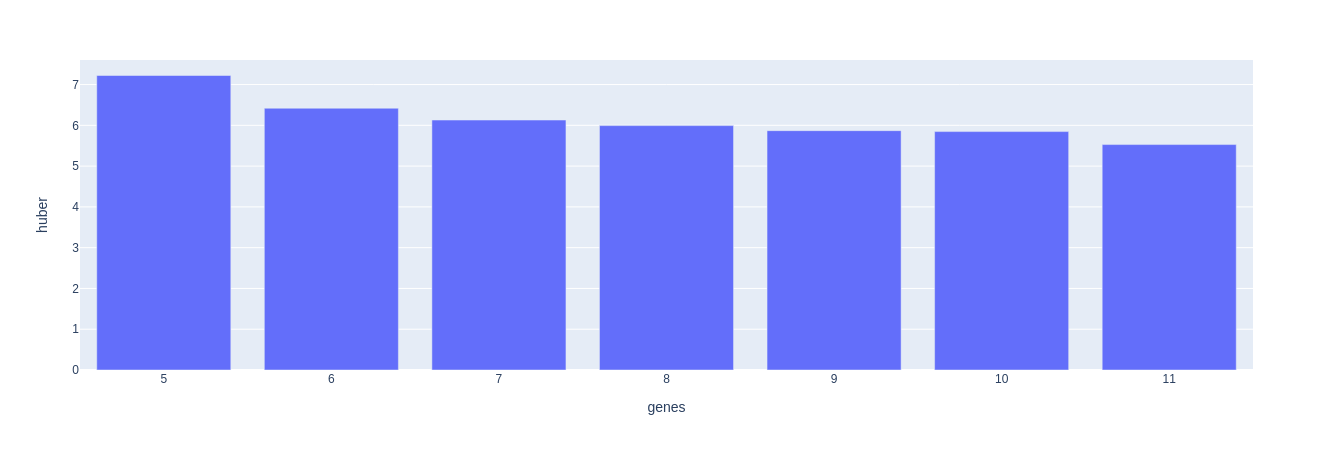

In [160]:
import plotly.express as px
fig = px.bar(huber_pd, x="genes", y="huber")
fig

### Selected genes number ###

In [77]:
selected_result = lifespan_results[genes_index]
selected_result

FeatureSummary(results=[<table border='2'><caption><h3>Feature selection results</h3><caption><tr style='text-align:center'><th>selected</th><th>metrics</th><th>hold out metrics</th></tr><tr><td><div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>symbol</th>
      <th>shap_absolute_sum_to_lifespan</th>
      <th>shap_mean</th>
      <th>kendall_tau_to_lifespan</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>ENSG00000006282</th>
      <td>SPATA20</td>
      <td>6.823</td>
      <td>0.293</td>
      <td>0.559</td>
    </tr>
    <tr>
      <th>ENSG00000170835</th>
      <td>CEL</td>
      <td>6.252</td>
      <td>-0.155</td>
      <td>0.704</td>
    </tr>
    <tr>
      <th>ENSG00000172531</th>
      <td>PPP1CA</td>
      <td>4.247</td>
      <td>-0.109</td>
      <td>-0.640</td>
    </tr>
    <tr>
      <th>ENSG00000136436</th>
      <td>CALCOCO2</td>
      <td>3.307</td>
      <td>0.086</td>
      <td>0.746</td>
    </tr>
    <tr>
      <th>ENSG00000188747</th>
      <td>NOXA1</td>
      <td>2.773</td>
      <td>0.089</td>
      <td>0.658</td>
    </tr>
    <tr>
      <th>ENSG00000198663</th>
      <td>C6orf89</td>
      <td>2.612</td>
      <td>-0.127</td>
      <td>-0.735</td>
    </tr>
  </tbody>
</table>
</div></th><th><div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>R^2</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>huber</th>
      <th>validation_species</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.677</td>
      <td>9.128</td>
      <td>299.015</td>
      <td>7.879</td>
      <td>[Gorilla_gorilla, Pan_paniscus]</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0.477</td>
      <td>8.987</td>
      <td>372.183</td>
      <td>7.756</td>
      <td>[Heterocephalus_glaber, Capra_hircus]</td>
    </tr>
    <tr>
      <th>2</th>
      <td>0.723</td>
      <td>7.175</td>
      <td>191.276</td>
      <td>6.143</td>
      <td>[Bos_taurus, Otolemur_garnettii]</td>
    </tr>
    <tr>
      <th>3</th>
      <td>0.664</td>
      <td>6.058</td>
      <td>175.232</td>
      <td>5.115</td>
      <td>[Macaca_nemestrina, Microcebus_murinus]</td>
    </tr>
    <tr>
      <th>4</th>
      <td>0.674</td>
      <td>6.752</td>
      <td>213.433</td>
      <td>5.763</td>
      <td>[Felis_catus, Pan_troglodytes]</td>
    </tr>
  </tbody>
</table>
</div></th><th></th></tr></table>, <table border='2'><caption><h3>Feature selection results</h3><caption><tr style='text-align:center'><th>selected</th><th>metrics</th><th>hold out metrics</th></tr><tr><td><div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>symbol</th>
      <th>shap_absolute_sum_to_lifespan</th>
      <th>shap_mean</th>
      <th>kendall_tau_to_lifespan</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>ENSG00000006282</th>
      <td>SPATA20</td>
      <td>6.833</td>
      <td>0.132</td>
      <td>0.541</td>
    </tr>
    <tr>
      <th>ENSG00000170835</th>
      <td>CEL</td>
      <td>6.446</td>
      <td>0.019</td>
      <td>0.698</td>
    </tr>
    <tr>
      <th>ENSG00000172531</th>
      <td>PPP1CA</td>
      <td>4.196</td>
      <td>0.013</td>
      <td>-0.652</td>
    </t

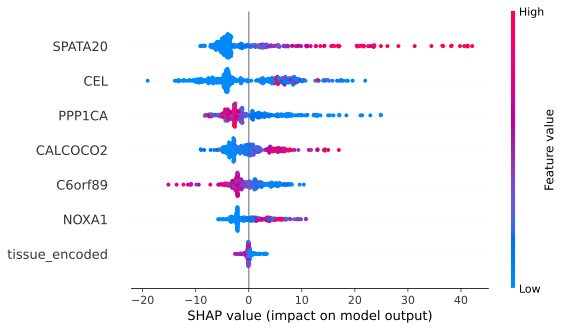

In [144]:
selected_result.plot(save=locations.output.plots / "stage_3" / "stage_3_summary.svg")

min_max dataset values: (3.3, 122.5)


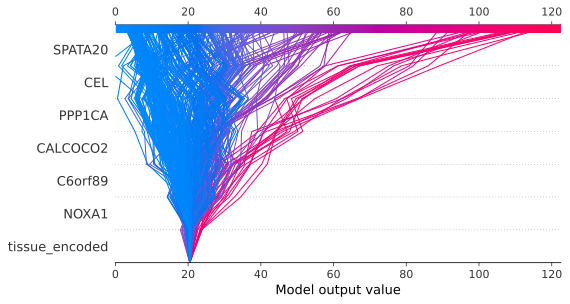

In [79]:
selected_result.plot_decision(save=locations.output.plots / "stage_3" / "stage_3_decision.svg")

min_max dataset values: (3.3, 122.5)


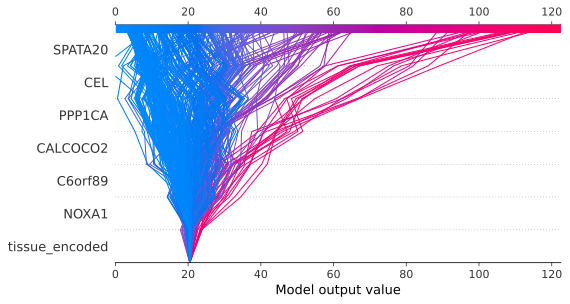

In [169]:
selected_result.plot_decision(save=locations.output.plots / "stage_3" / "stage_3_decision_terrible_short_version.svg", auto_size_plot=True)

In [95]:
def plot_tissue(tissue: str):
    d = selection(genes_num)[0]
    new_d = d.by_samples.filter(lambda s: s.tissue == tissue)
    new_sh = selected_result.filter_shap_by_data_samples(new_d)
    print(new_sh.shape, selected_result.stable_shap_values.shape)
    return selected_result.plot_decision(custom_shap_values = new_sh)

(139, 7) (408, 7)
min_max dataset values: (3.3, 122.5)


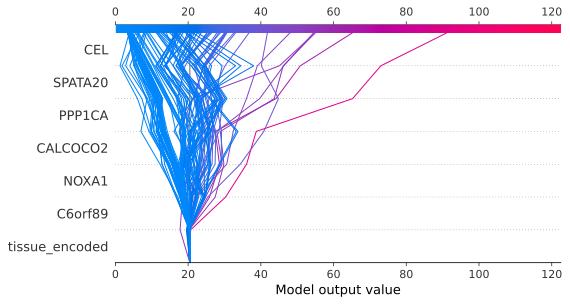

In [96]:
plot_tissue("Liver")

../yspecies/explanations.py:236: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(65, 7) (408, 7)
min_max dataset values: (3.3, 122.5)


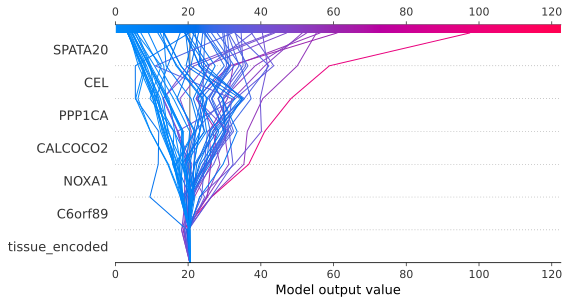

In [97]:
plot_tissue("Kidney")

../yspecies/explanations.py:236: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(132, 7) (408, 7)
min_max dataset values: (3.3, 122.5)


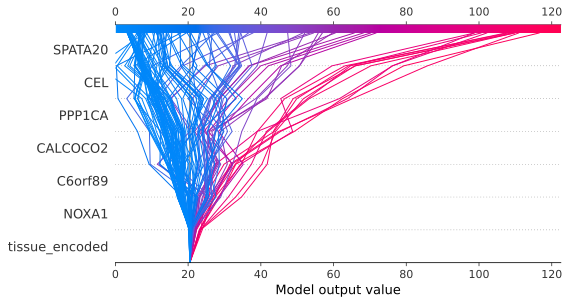

In [98]:
plot_tissue("Brain")

../yspecies/explanations.py:236: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(39, 7) (408, 7)
min_max dataset values: (3.3, 122.5)


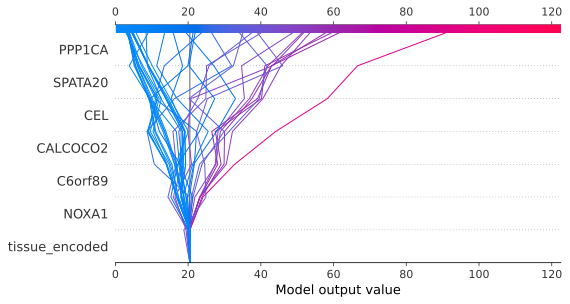

In [99]:
plot_tissue("Heart")

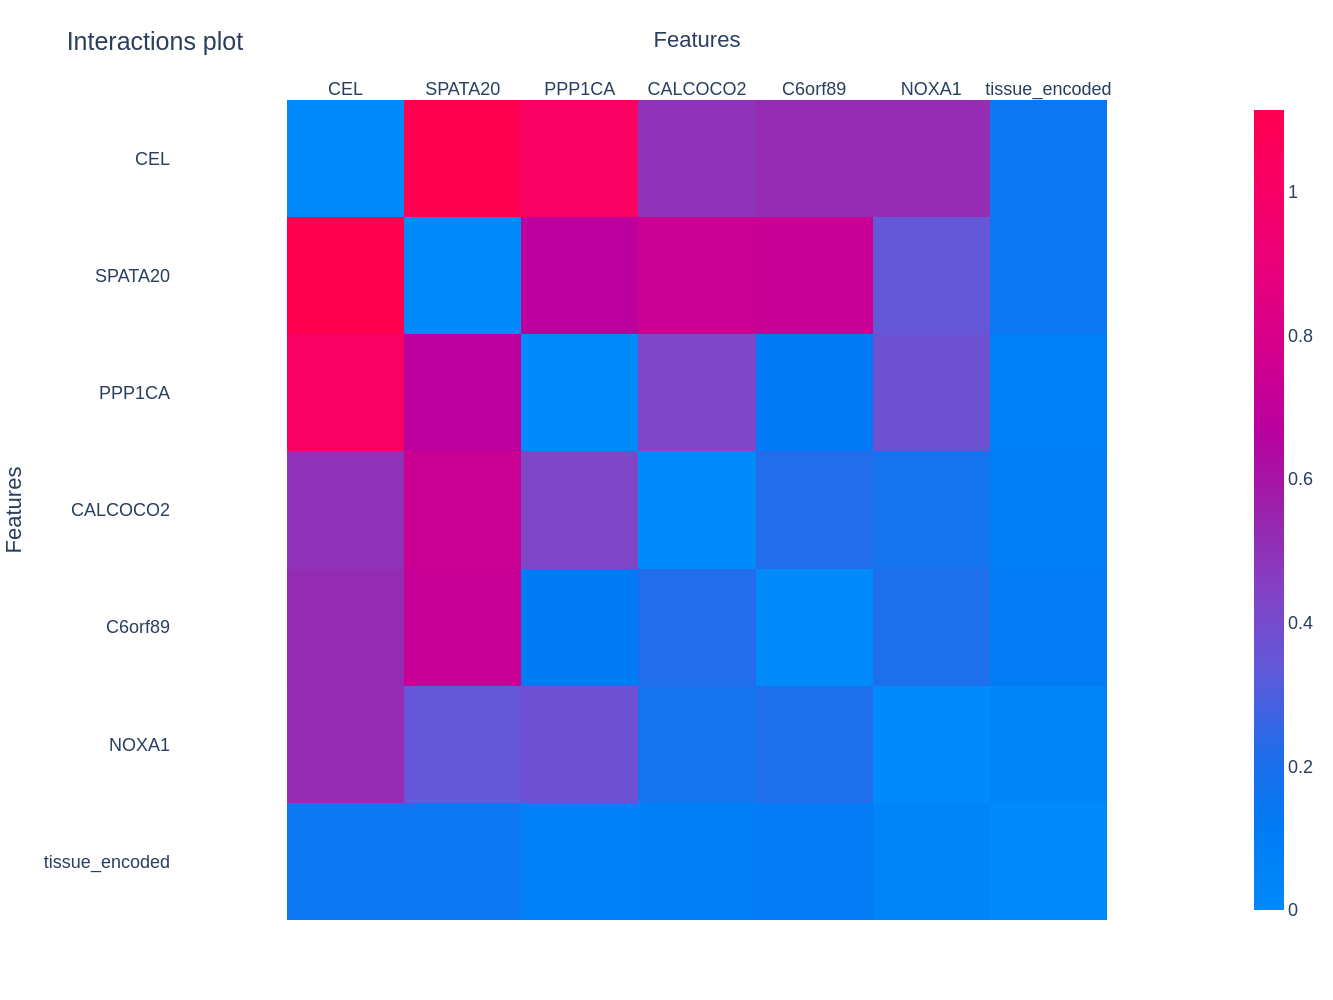

In [101]:
selected_result.plot_interactions(height=1000, width=1090)

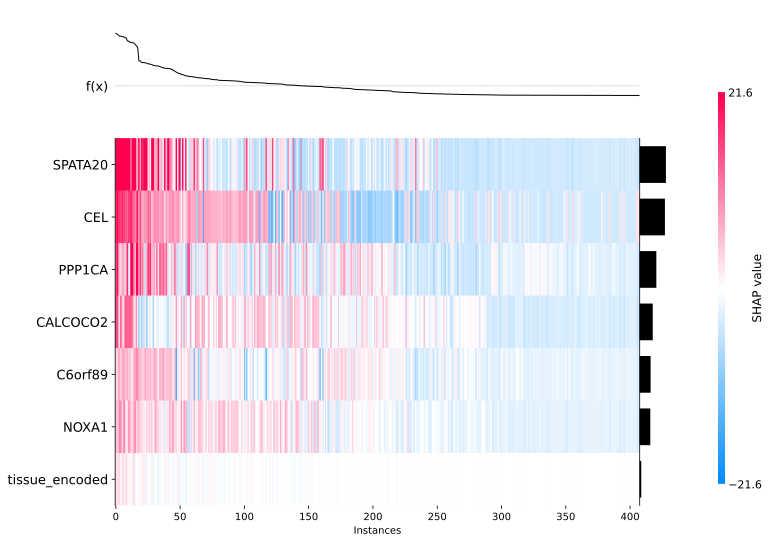

In [111]:
selected_result.plot_heatmap(sort_by_clust=False, save=locations.output.plots / "stage_3" / "stage_3_heatmap_unclustered.svg")

### Dependency plots for the most interesting interactions ###

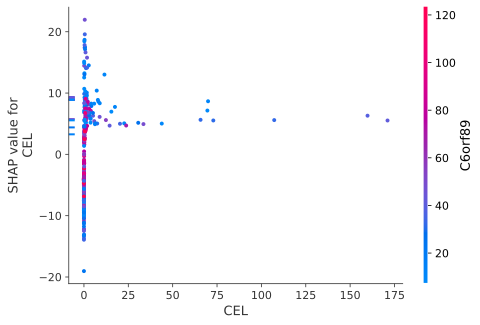

In [114]:
selected_result.plot_dependency("CEL", "C6orf89", save=locations.output.plots / "stage_3" / "interactions" / "CEL_C6orf89.svg")

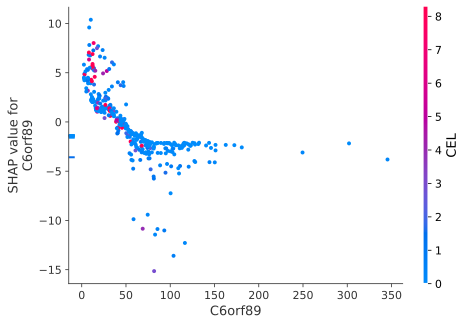

In [116]:
selected_result.plot_dependency("C6orf89","CEL", save=locations.output.plots / "stage_3" / "interactions" / "C6orf89_CEL.svg")

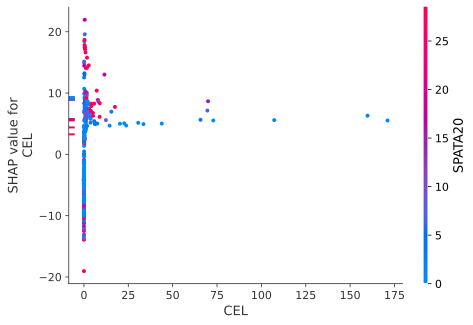

In [117]:
selected_result.plot_dependency("CEL", "SPATA20", save=locations.output.plots / "stage_3" / "interactions" / "CEL_SPATA20.svg")

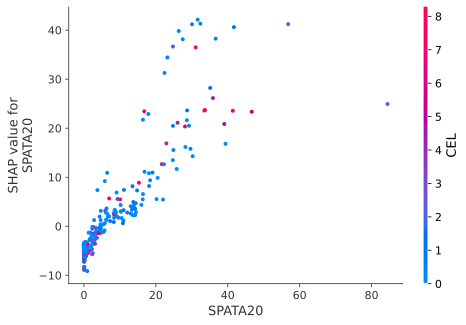

In [118]:
selected_result.plot_dependency("SPATA20", "CEL", save=locations.output.plots / "stage_3" / "interactions" / "SPATA20_CEL.svg")

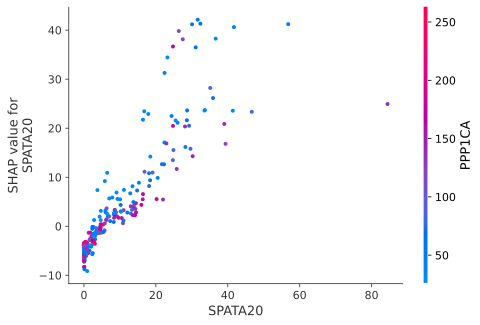

In [105]:
selected_result.plot_dependency("SPATA20", "PPP1CA")

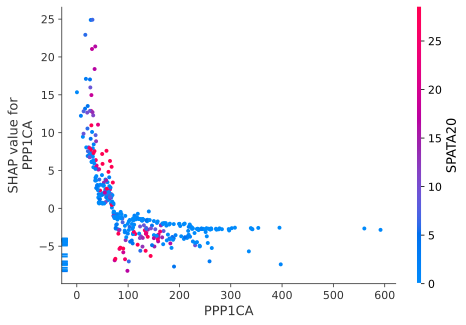

In [142]:
selected_result.plot_dependency("PPP1CA", "SPATA20", save=locations.output.plots / "stage_3" / "interactions" / "PPP1CA_SPATA20.svg")

# Life history checks #

In [119]:
from yspecies.preprocess import FeatureSelection
from yspecies.explanations import FeatureResults, FeatureSummary

In [123]:
from dataclasses import replace
other_life = [t for t in life_history if t != trait]
#sps = ["order"] + 
sps = other_life
life_pipe = factory.make_repeated_shap_pipeline(study_path = opt_by_trait(trait, f"_{stage_num}"), study_name=f"lifespan_r2_huber_kendall", opt_metrics = "huber")
life_pipe_debug = factory.make_shap_pipeline(study_path = opt_by_trait("lifespan"), study_name=f"lifespan_r2_huber_kendall", opt_metrics = "huber")
life_history_selection = replace(default_selection,species = sps, samples=["species"], categorical = [], not_validated_species = data.min_max_trait(trait))
life_history_selection

../yspecies/helpers.py:33: ExperimentalWarning:

create_study is experimental (supported from v1.4.0). The interface can change in the future.

/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/optuna/multi_objective/study.py:114: ExperimentalWarning:

NSGAIIMultiObjectiveSampler is experimental (supported from v1.5.0). The interface can change in the future.

/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/optuna/multi_objective/samplers/_nsga2.py:90: ExperimentalWarning:

RandomMultiObjectiveSampler is experimental (supported from v1.4.0). The interface can change in the future.

[I 2020-11-15 06:19:26,758] Using an existing study with name 'lifespan_r2_huber_kendall' instead of creating a new one.


loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/lifespan_3.sqlite


/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/optuna/multi_objective/study.py:133: ExperimentalWarning:

MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.

/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/optuna/multi_objective/study.py:442: ExperimentalWarning:

FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.

[I 2020-11-15 06:19:27,235] Using an existing study with name 'lifespan_r2_huber_kendall' instead of creating a new one.


loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/lifespan.sqlite


FeatureSelection(samples=['species'], species=['mass_kg', 'mtGC', 'metabolic_rate', 'temperature', 'gestation_days'], genes=None, to_predict='lifespan', categorical=[], exclude_from_training=['species'], genes_meta=None, select_by='shap', importance_type='split', feature_perturbation='tree_path_dependent', not_validated_species=['Mus_caroli', 'Homo_sapiens'])

In [124]:
lifespan_results_his = life_pipe.fit_transform((selection(genes_num,"lifespan")[0],life_history_selection))
lifespan_results_his.selected

2020-11-15 06:19:32.946 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 0 =====
2020-11-15 06:19:32.948 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}
2020-11-15 06:19:32.952 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument

/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/callback.py:186: UserWarning:

Ear

[250]	valid_0's l1: 3.04201	valid_0's l2: 24.8748	valid_0's huber: 2.46762


2020-11-15 06:19:35.034 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


[250]	valid_0's l1: 1.75707	valid_0's l2: 8.78397	valid_0's huber: 1.31238


2020-11-15 06:19:35.504 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


[250]	valid_0's l1: 5.74181	valid_0's l2: 243.002	valid_0's huber: 4.9077


2020-11-15 06:19:36.055 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Pan_troglodytes']


[250]	valid_0's l1: 1.3436	valid_0's l2: 4.75066	valid_0's huber: 0.921679
[250]	valid_0's l1: 1.71254	valid_0's l2: 9.27966	valid_0's huber: 1.27681


2020-11-15 06:19:37.599 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.9172059536769351, MAE=2.719403419342817, MSE=58.13817092482243, huber=2.1772380597874785)
2020-11-15 06:19:37.604 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 1 =====
2020-11-15 06:19:37.605 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-11-15 06:19:37.608 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engin

[250]	valid_0's l1: 2.78852	valid_0's l2: 23.1264	valid_0's huber: 2.24276


2020-11-15 06:19:38.760 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 2.27014	valid_0's l2: 24.0302	valid_0's huber: 1.77636


2020-11-15 06:19:39.304 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


[250]	valid_0's l1: 1.12057	valid_0's l2: 3.66831	valid_0's huber: 0.742227


2020-11-15 06:19:39.792 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 1.42202	valid_0's l2: 4.4594	valid_0's huber: 0.986561
[250]	valid_0's l1: 1.1512	valid_0's l2: 7.70931	valid_0's huber: 0.779301


2020-11-15 06:19:41.362 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.9822967934864495, MAE=1.7504891534893894, MSE=12.59872916479055, huber=1.305440695068104)
2020-11-15 06:19:41.367 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 2 =====
2020-11-15 06:19:41.367 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-11-15 06:19:41.370 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightg

[250]	valid_0's l1: 3.49223	valid_0's l2: 26.4735	valid_0's huber: 2.81017


2020-11-15 06:19:42.500 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 3.50045	valid_0's l2: 26.0871	valid_0's huber: 2.80741


2020-11-15 06:19:43.067 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


[250]	valid_0's l1: 4.00649	valid_0's l2: 49.4138	valid_0's huber: 3.28095


2020-11-15 06:19:43.607 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Tupaia_belangeri']


[250]	valid_0's l1: 2.02096	valid_0's l2: 8.02635	valid_0's huber: 1.44304
[250]	valid_0's l1: 8.62738	valid_0's l2: 295.538	valid_0's huber: 7.42295


2020-11-15 06:19:45.360 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.8844605365624169, MAE=4.329502861943633, MSE=81.10775862908153, huber=3.55290495368794)
2020-11-15 06:19:45.364 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 3 =====
2020-11-15 06:19:45.365 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-11-15 06:19:45.368 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engi

[250]	valid_0's l1: 3.90068	valid_0's l2: 47.3812	valid_0's huber: 3.18337


2020-11-15 06:19:46.335 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


[250]	valid_0's l1: 2.57523	valid_0's l2: 13.8583	valid_0's huber: 2.01083


2020-11-15 06:19:46.808 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


[250]	valid_0's l1: 6.56442	valid_0's l2: 270.752	valid_0's huber: 5.61956


2020-11-15 06:19:47.296 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


[250]	valid_0's l1: 1.22405	valid_0's l2: 4.27287	valid_0's huber: 0.791255
[250]	valid_0's l1: 1.48346	valid_0's l2: 5.38751	valid_0's huber: 1.02913


2020-11-15 06:19:48.927 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.9089836294499207, MAE=3.149565941001824, MSE=68.3303774921338, huber=2.526830895013316)
2020-11-15 06:19:48.932 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 4 =====
2020-11-15 06:19:48.933 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-11-15 06:19:48.936 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/

[250]	valid_0's l1: 1.63059	valid_0's l2: 11.0298	valid_0's huber: 1.19938


2020-11-15 06:19:49.926 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


[250]	valid_0's l1: 1.85788	valid_0's l2: 8.81973	valid_0's huber: 1.40008


2020-11-15 06:19:50.382 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


[250]	valid_0's l1: 3.0993	valid_0's l2: 31.1886	valid_0's huber: 2.52768


2020-11-15 06:19:50.856 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Equus_caballus']


[250]	valid_0's l1: 3.07242	valid_0's l2: 24.7805	valid_0's huber: 2.47129
[250]	valid_0's l1: 3.03717	valid_0's l2: 43.6026	valid_0's huber: 2.47131


2020-11-15 06:19:52.586 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.9642790818680105, MAE=2.539471055130897, MSE=23.884244021676466, huber=2.0139476944687376)
2020-11-15 06:19:52.591 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 5 =====
2020-11-15 06:19:52.591 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-11-15 06:19:52.595 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/ligh

[250]	valid_0's l1: 1.56264	valid_0's l2: 7.24445	valid_0's huber: 1.13609


2020-11-15 06:19:53.548 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 1.60843	valid_0's l2: 5.32476	valid_0's huber: 1.15062


2020-11-15 06:19:54.017 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 1.94094	valid_0's l2: 10.7535	valid_0's huber: 1.46986


2020-11-15 06:19:54.512 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 2.98923	valid_0's l2: 33.1185	valid_0's huber: 2.40422
[250]	valid_0's l1: 1.78056	valid_0's l2: 9.17953	valid_0's huber: 1.32363


2020-11-15 06:19:56.166 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.981041396278103, MAE=1.976360165302322, MSE=13.12414877412606, huber=1.496885860472273)
2020-11-15 06:19:56.171 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 6 =====
2020-11-15 06:19:56.172 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-11-15 06:19:56.175 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packag

[250]	valid_0's l1: 2.47275	valid_0's l2: 16.0797	valid_0's huber: 1.9181


2020-11-15 06:19:57.153 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


[250]	valid_0's l1: 1.59881	valid_0's l2: 6.53975	valid_0's huber: 1.13437


2020-11-15 06:19:57.686 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


[250]	valid_0's l1: 2.27706	valid_0's l2: 15.204	valid_0's huber: 1.74143


2020-11-15 06:19:58.213 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Sus_scrofa']


[250]	valid_0's l1: 3.54743	valid_0's l2: 25.9581	valid_0's huber: 2.85729
[250]	valid_0's l1: 2.81882	valid_0's l2: 32.1571	valid_0's huber: 2.22623


2020-11-15 06:20:00.175 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.9718565830281101, MAE=2.542973351159477, MSE=19.18773752813981, huber=1.9754845324753803)
2020-11-15 06:20:00.180 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 7 =====
2020-11-15 06:20:00.180 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-11-15 06:20:00.184 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/eng

[250]	valid_0's l1: 2.82256	valid_0's l2: 16.6326	valid_0's huber: 2.23734


2020-11-15 06:20:01.165 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 3.35222	valid_0's l2: 43.3118	valid_0's huber: 2.73536


2020-11-15 06:20:01.654 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


[250]	valid_0's l1: 1.37772	valid_0's l2: 4.13901	valid_0's huber: 0.947161


2020-11-15 06:20:02.150 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 1.87841	valid_0's l2: 8.93458	valid_0's huber: 1.40549
[250]	valid_0's l1: 2.79258	valid_0's l2: 36.1776	valid_0's huber: 2.23234


2020-11-15 06:20:03.765 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.9697316259970525, MAE=2.444697902588982, MSE=21.839121422865624, huber=1.9115376834114652)
2020-11-15 06:20:03.769 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 8 =====
2020-11-15 06:20:03.770 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-11-15 06:20:03.773 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/e

[250]	valid_0's l1: 3.32798	valid_0's l2: 42.72	valid_0's huber: 2.69286


2020-11-15 06:20:04.816 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


[250]	valid_0's l1: 2.49802	valid_0's l2: 20.7102	valid_0's huber: 1.94058


2020-11-15 06:20:05.315 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


[250]	valid_0's l1: 1.92637	valid_0's l2: 12.1584	valid_0's huber: 1.4575


2020-11-15 06:20:05.818 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


[250]	valid_0's l1: 5.64965	valid_0's l2: 203.166	valid_0's huber: 4.78949
[250]	valid_0's l1: 1.68805	valid_0's l2: 7.36352	valid_0's huber: 1.23098


2020-11-15 06:20:07.464 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.9131175258838293, MAE=3.018013573105855, MSE=57.223674621838725, huber=2.4222824600284976)
2020-11-15 06:20:07.469 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 9 =====
2020-11-15 06:20:07.470 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1678514050581442, 'feature_fraction': 0.7820118352847027, 'lambda_l1': 2.9902884884096714, 'lambda_l2': 0.221388108944887, 'learning_rate': 0.09295786688959959, 'max_depth': 5, 'max_leaves': 16, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-11-15 06:20:07.473 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages

[250]	valid_0's l1: 1.76354	valid_0's l2: 7.20883	valid_0's huber: 1.30651


2020-11-15 06:20:08.437 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


[250]	valid_0's l1: 2.17349	valid_0's l2: 10.3134	valid_0's huber: 1.65647


2020-11-15 06:20:09.073 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


[250]	valid_0's l1: 1.45456	valid_0's l2: 8.49083	valid_0's huber: 1.01705


2020-11-15 06:20:09.618 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Felis_catus']


[250]	valid_0's l1: 2.24945	valid_0's l2: 10.6488	valid_0's huber: 1.70488
[250]	valid_0's l1: 2.46129	valid_0's l2: 15.9333	valid_0's huber: 1.92018


2020-11-15 06:20:11.559 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.9844767971935122, MAE=2.0204679509328387, MSE=10.51904110636761, huber=1.5210167554042322)


symbol  repeats  mean_abs_shap  mean_kendall_tau  shap_0  \
ENSG00000170835       CEL   10.000          1.062             0.782   1.051   
ENSG00000136436  CALCOCO2   10.000          0.435             0.791   0.492   
ENSG00000198663   C6orf89   10.000          0.420            -0.730   0.434   
ENSG00000188747     NOXA1   10.000          0.238             0.708   0.251   
ENSG00000172531    PPP1CA   10.000          0.153            -0.759   0.181   
ENSG00000006282   SPATA20   10.000          0.063            -0.177   0.065   

                 kendall_tau_0  shap_1  kendall_tau_1  shap_2  kendall_tau_2  \
ENSG00000170835          0.786   0.983          0.776   1.201          0.788   
ENSG00000136436          0.800   0.459          0.771   0.457          0.788   
ENSG00000198663         -0.751   0.462         -0.756   0.371         -0.745   
ENSG00000188747          0.732   0.225          0.744   0.192          0.651   
ENSG00000172531         -0.759   0.170         -0.772   0.160         -0.773   
ENSG00000006282         -0.149   0.076         -0.139   0.043         -0.114   

                 shap_3  kendall_tau_3  shap_4  kendall_tau_4  shap_5  \
ENSG00000170835   1.145          0.767   1.112          0.800   0.995   
ENSG00000136436   0.430          0.807   0.454          0.792   0.366   
ENSG00000198663   0.433         -0.722   0.384         -0.737   0.309   
ENSG00000188747   0.268          0.697   0.232          0.695   0.216   
ENSG00000172531   0.157         -0.743   0.119         -0.734   0.135   
ENSG00000006282   0.046         -0.199   0.049         -0.019   0.079   

                 kendall_tau_5  shap_6  kendall_tau_6  shap_7  kendall_tau_7  \
ENSG00000170835          0.770   0.990          0.778   1.071          0.791   
ENSG00000136436          0.794   0.398          0.781   0.491          0.810   
ENSG00000198663         -0.711   0.444         -0.706   0.493         -0.725   
ENSG00000188747          0.718   0.310          0.688   0.258          0.728   
ENSG00000172531         -0.785   0.126         -0.753   0.192         -0.786   
ENSG00000006282         -0.198   0.074         -0.495   0.066         -0.032   

                 shap_8  kendall_tau_8  shap_9  kendall_tau_9  
ENSG00000170835   1.122          0.786   0.954          0.780  
ENSG00000136436   0.390          0.806   0.409          0.761  
ENSG00000198663   0.479         -0.726   0.391         -0.721  
ENSG00000188747   0.218          0.704   0.213          0.721  
ENSG00000172531   0.142         -0.762   0.153         -0.724  
ENSG00000006282   0.051         -0.112   0.078         -0.309

In [134]:
lifespan_results_his.metrics_average

Metrics(R2=0.9477449923424339, MAE=2.6490945373998036, MSE=36.595300368584255, huber=2.090356958981743)

min_max dataset values: (3.3, 122.5)


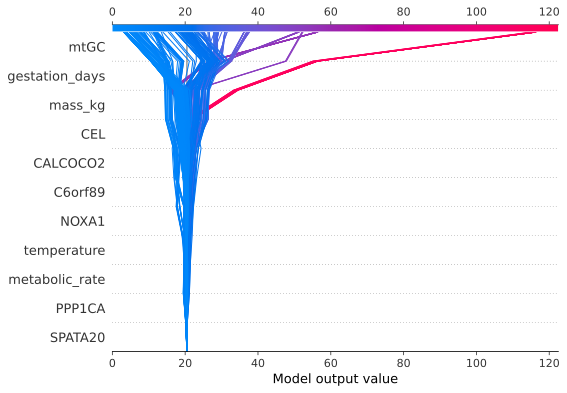

In [131]:
lifespan_results_his.plot_decision(save=locations.output.plots / "stage_3" / "life_history" / "stage_3_lh_decision.svg")

min_max dataset values: (3.3, 122.5)


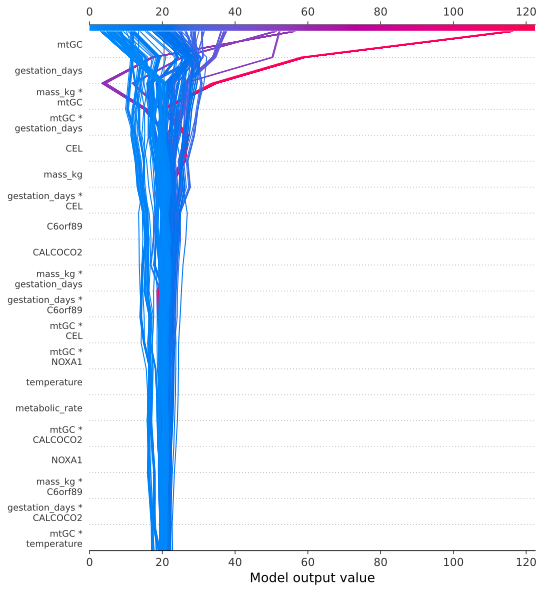

In [132]:
lifespan_results_his.plot_interaction_decision(save=locations.output.plots / "stage_3" / "life_history" / "stage_3_lh_decision_interactions.svg")

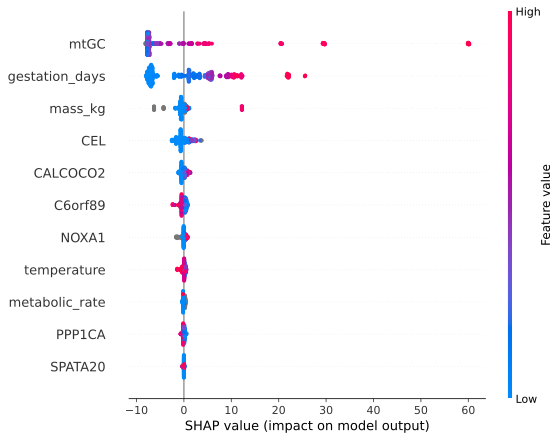

In [135]:
lifespan_results_his.plot(save=locations.output.plots / "stage_3" / "life_history" / "stage_3_lh_summary.svg")

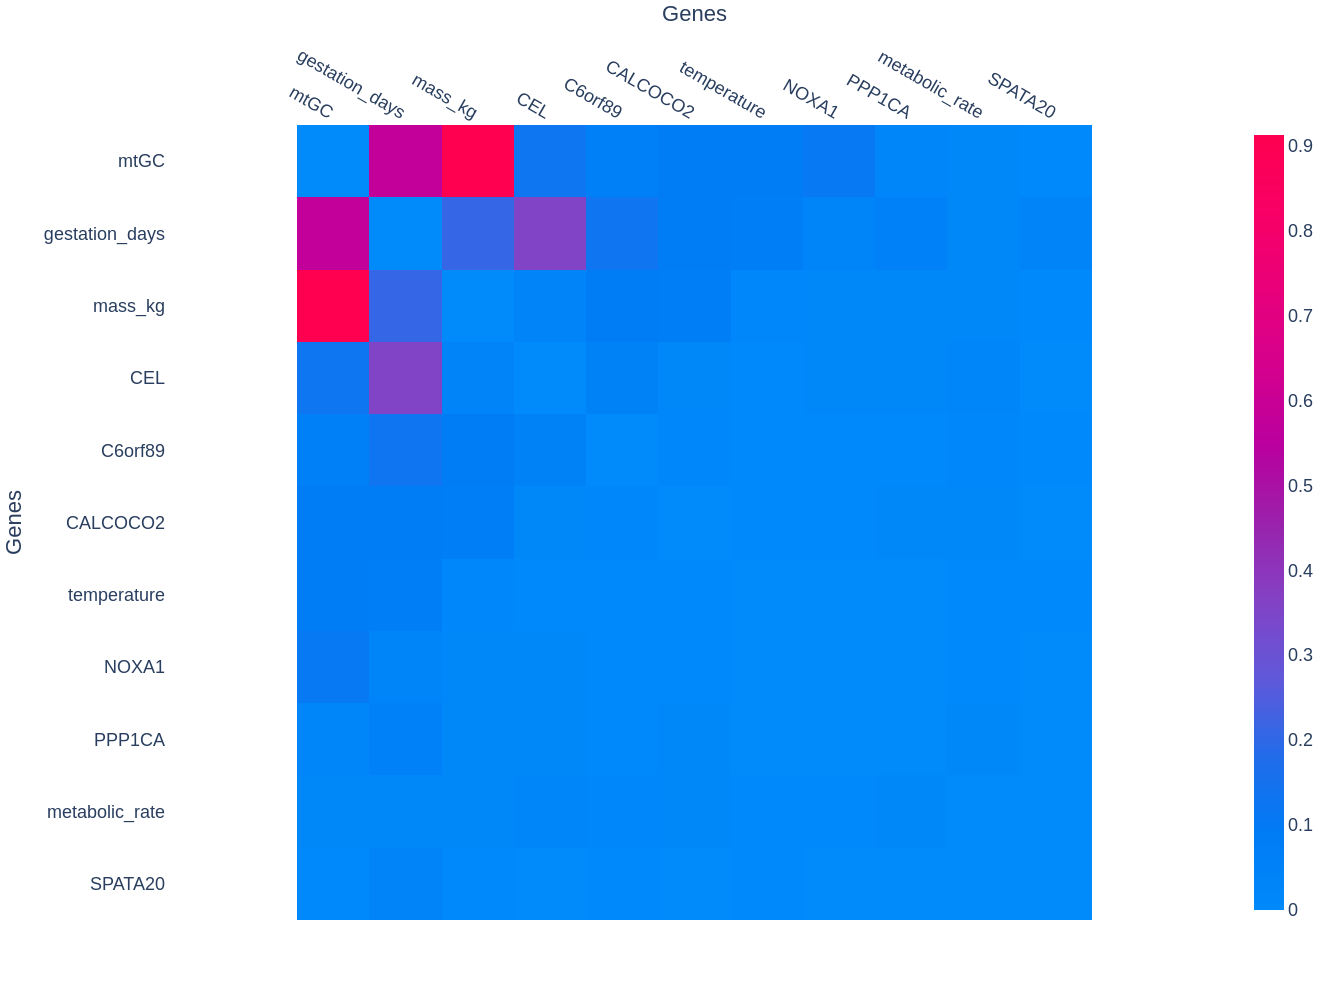

In [136]:
lifespan_results_his.plot_interactions(height=1000, width=1090, max=15, title="", axis_title="Genes")

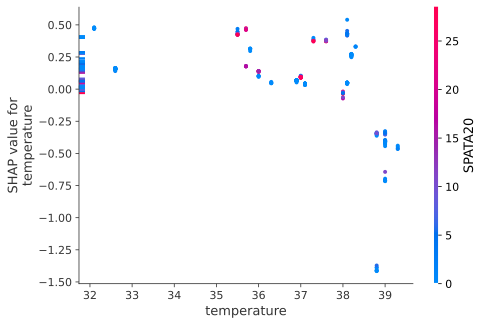

In [137]:
lifespan_results_his.plot_dependency("temperature", "SPATA20", save=locations.output.plots / "stage_3" / "life_history"/ "interactions" / "temperature_SPATA20.svg")

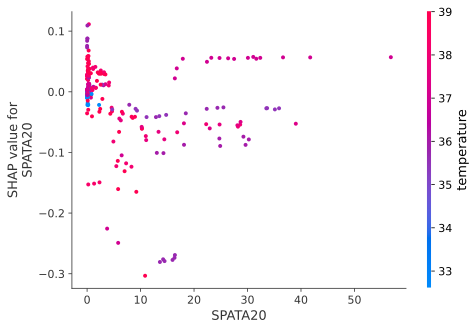

In [138]:
lifespan_results_his.plot_dependency("SPATA20", "temperature", save=locations.output.plots / "stage_3" / "life_history"/ "interactions" / "SPATA20_temperature.svg")

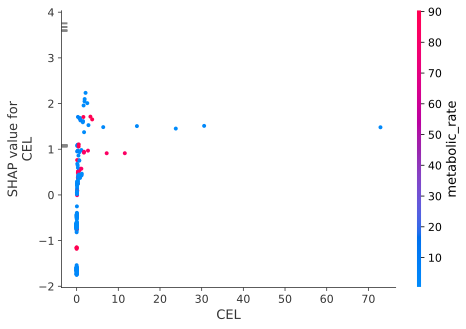

In [139]:
lifespan_results_his.plot_dependency("CEL", "metabolic_rate", save=locations.output.plots / "stage_3" / "life_history"/ "interactions" / "CEL_metabolic_rate.svg")

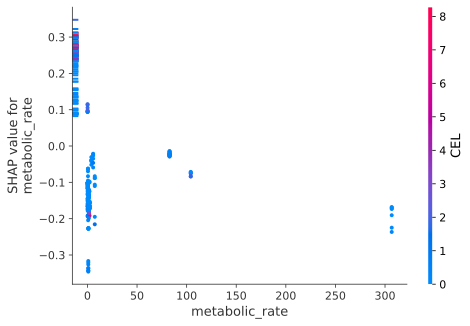

In [140]:
lifespan_results_his.plot_dependency("metabolic_rate","CEL", save=locations.output.plots / "stage_3" / "life_history"/ "interactions" / "metabolic_rate_CEL.svg")